In [ ]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei', 'Arial Unicode MS'] # 支持中文
plt.rcParams['axes.unicode_minus'] = False # 负号正常显示


df = pd.read_feather(
    r'C:\Users\ZHOU\Documents\2025CUHK\兴银\需要拷的数据\packages\L1_01\2024-09-11.feather'
)
print(df['stock_code'].unique())
#pd.set_option('display.max_rows',None)
#pd.reset_option('display.max_rows')
print(df.head(1000))


[     1      2      4 ... 688819 688981 689009]
       time  stock_code  open  high   low  close   volume       amount
0     93000           1  9.88  9.88  9.86   9.86   238800   2358816.00
1     93100           1  9.86  9.87  9.83   9.84  1136100  11192628.00
2     93200           1  9.83  9.86  9.83   9.86   362500   3567821.00
3     93300           1  9.85  9.86  9.83   9.84   833200   8200118.00
4     93400           1  9.84  9.84  9.82   9.83   703244   6911987.08
..      ...         ...   ...   ...   ...    ...      ...          ...
995  100100           7  4.74  4.74  4.73   4.74     3200     15145.00
996  100200           7  4.74  4.74  4.74   4.74      100       474.00
997  100300           7  4.73  4.73  4.73   4.73    18500     87505.00
998  100400           7  4.73  4.73  4.72   4.72    54800    258658.00
999  100500           7  4.71  4.71  4.71   4.71     8700     40977.00

[1000 rows x 8 columns]


In [ ]:
import pandas as pd
import numpy as np

# 1. 剔除开盘前15分钟（9:30:00 ~ 9:44:00）
df = df[df['time']>=94500] # 9:45之后
df['minute'] = df['time']//100
# 2. 找到每只股票每天成交量最大的10个分钟（海量时刻）
top10 = (
df.groupby(['stock_code'], group_keys=False)
.apply(lambda x: x.nlargest(10, 'volume'))
.reset_index(drop=True)
)

top10

In [8]:
# 3. 按时间排序，筛选“优势时刻”

def filter_advantage_minutes(x):
# x已按minute升序
    diff = x['minute'].diff().fillna(9999)
    keep = (diff > 5)
    keep.iloc[0] = True #第一个保留
    return x[keep]
top10 = top10.sort_values(['stock_code', 'minute'])
advantage = (
top10.groupby(['stock_code'], group_keys=False)
.apply(filter_advantage_minutes)
.reset_index(drop=True)
)
advantage

,time,stock_code,open,high,low,close,volume,amount,minute,future5_volume
0,101300,1,9.83,9.83,9.81,9.82,1502556,14755154.92,1013,2923956.0
1,110200,1,9.81,9.81,9.80,9.80,2921900,28656518.00,1102,6367000.0
2,111200,1,9.78,9.78,9.76,9.77,2672500,26124232.00,1112,5303100.0
3,130100,1,9.74,9.75,9.73,9.74,1452400,14141389.00,1301,2489900.0
4,130800,1,9.72,9.72,9.70,9.70,3086400,29977268.00,1308,7310928.0
...,...,...,...,...,...,...,...,...,...,...
34379,95100,689009,45.83,46.10,45.83,46.07,163939,7531199.00,951,342012.0
34380,103700,689009,45.18,45.19,45.08,45.17,96810,4369692.00,1037,289389.0
34381,131600,689009,44.13,44.28,44.13,44.28,98975,4377191.00,1316,449349.0
34382,142200,689009,45.59,45.69,45.50,45.66,106992,4882568.00,1422,445688.0


In [9]:
# 4. 计算跟随系数
# 计算未来5分钟成交量和
df['future5_volume'] = (
df.groupby(['stock_code'])['volume']
.apply(lambda x: x.rolling(window=5, min_periods=1).sum().shift(-4))
)
print(df[df['minute']==1013])

advantage = advantage.merge(
df[['stock_code', 'minute', 'future5_volume']],
on=['stock_code', 'minute'],
how='left'
)
advantage

           time  stock_code   open   high    low  close   volume       amount  \
43       101300           1   9.83   9.83   9.81   9.82  1502556  14755154.92   
284      101300           2   6.32   6.32   6.31   6.31   103600    654029.00   
525      101300           4  11.62  11.62  11.61  11.62    35300    410000.00   
766      101300           6   4.14   4.14   4.14   4.14    64400    266616.00   
1007     101300           7   4.71   4.72   4.71   4.72    22700    106920.00   
...         ...         ...    ...    ...    ...    ...      ...          ...   
1227938  101300      688799  38.13  38.13  38.13  38.13        0         0.00   
1228179  101300      688800  20.95  20.97  20.95  20.96    23598    494245.00   
1228420  101300      688819  27.48  27.52  27.45  27.52    37199   1022529.00   
1228661  101300      688981  44.08  44.09  44.07  44.07   106938   4713977.00   
1228902  101300      689009  45.57  45.58  45.54  45.54    33463   1524806.00   

         minute  future5_vo

,time,stock_code,open,high,low,close,volume,amount,minute,future5_volume_x,future5_volume_y
0,101300,1,9.83,9.83,9.81,9.82,1502556,14755154.92,1013,2923956.0,2923956.0
1,110200,1,9.81,9.81,9.80,9.80,2921900,28656518.00,1102,6367000.0,6367000.0
2,111200,1,9.78,9.78,9.76,9.77,2672500,26124232.00,1112,5303100.0,5303100.0
3,130100,1,9.74,9.75,9.73,9.74,1452400,14141389.00,1301,2489900.0,2489900.0
4,130800,1,9.72,9.72,9.70,9.70,3086400,29977268.00,1308,7310928.0,7310928.0
...,...,...,...,...,...,...,...,...,...,...,...
34379,95100,689009,45.83,46.10,45.83,46.07,163939,7531199.00,951,342012.0,342012.0
34380,103700,689009,45.18,45.19,45.08,45.17,96810,4369692.00,1037,289389.0,289389.0
34381,131600,689009,44.13,44.28,44.13,44.28,98975,4377191.00,1316,449349.0,449349.0
34382,142200,689009,45.59,45.69,45.50,45.66,106992,4882568.00,1422,445688.0,445688.0


In [ ]:
# “跟随系数” = 跟随时刻（未来5分钟）成交量 / 优势时刻成交量
advantage['follow_coef'] = advantage['future5_volume'] / advantage['volume']


## 2.1 “待著而救”因子构建

In [18]:
import pandas as pd
import numpy as np
import glob
import os
from tqdm import tqdm  # 进度条

data_dir = r'C:\Users\ZHOU\Documents\2025CUHK\兴银\需要拷的数据\packages\L1_01'
all_files = sorted(glob.glob(os.path.join(data_dir, '*.feather')))

result_list = []

for file in tqdm(all_files, desc="Processing files"):
    date_str = os.path.basename(file).split('.')[0]
    df = pd.read_feather(file)
    df['date'] = pd.to_datetime(date_str)
    # 1. 剔除开盘前15分钟
    df = df[df['time'] >= 94500]
    df['minute'] = df['time'] // 100
    # 2. 找到每只股票当天成交量最大的10个分钟
    top10 = (
        df.groupby(['stock_code'], group_keys=False)
        .apply(lambda x: x.nlargest(10, 'volume'))
        .reset_index(drop=True)
    )
    # 3. 按时间排序，筛选“优势时刻”
    def filter_advantage_minutes(x):
        diff = x['minute'].diff().fillna(9999)
        keep = (diff > 5)
        keep.iloc[0] = True
        return x[keep]
    top10 = top10.sort_values(['stock_code', 'minute'])
    advantage = (
        top10.groupby(['stock_code'], group_keys=False)
        .apply(filter_advantage_minutes)
        .reset_index(drop=True)
    )
    # 4. 计算未来5分钟成交量和
    df['future5_volume'] = (
        df.groupby(['stock_code'])['volume']
        .apply(lambda x: x.rolling(window=5, min_periods=1).sum().shift(-4))
    )
    # 5. 合并，计算跟随系数
    advantage = advantage.merge(
        df[['stock_code', 'minute', 'future5_volume']],
        on=['stock_code', 'minute'],
        how='left'
    )
    advantage['follow_coef'] = advantage['future5_volume'] / advantage['volume']
    # 6. 计算每只股票当天的“日跟随系数”
    daily_follow = (
        advantage.groupby(['stock_code'])['follow_coef']
        .mean()
        .reset_index()
    )
    daily_follow['date'] = pd.to_datetime(date_str)
    result_list.append(daily_follow)

# 合并所有天的结果
all_daily_follow = pd.concat(result_list, ignore_index=True)

Processing files: 100%|██████████| 120/120 [20:31<00:00, 10.26s/it]


In [19]:
# 将数据转换为pivot格式：行为日期，列为股票代码，值为follow_coef
factor_pivot = all_daily_follow.pivot(index='date', columns='stock_code', values='follow_coef')

# 设置index名称为'_id'（与模板一致）
factor_pivot.index.name = '_id'

print(factor_pivot)

stock_code    1         2         4         6         7         8       \
_id                                                                      
2024-09-11  2.051658  2.148450  4.158168  2.723409  1.615952  1.839810   
2024-09-12  1.990439  2.567592  2.266072  2.165165  2.011063  1.822253   
2024-09-13  2.080822  2.957725  2.536987  4.113358  1.977389  1.657421   
2024-09-18  2.262986  3.533628  2.875446  3.618305  3.010509  1.720943   
2024-09-19  2.783150  2.888350  3.473568  2.271776  3.008905  1.695503   
...              ...       ...       ...       ...       ...       ...   
2025-03-11  2.488950  2.995008  2.341884  4.584284  1.610365  1.379181   
2025-03-12  2.550884  2.627577  1.979504  2.338218  1.675615  1.620694   
2025-03-13  2.657366  1.902581  2.596933  1.888820  2.130606  2.362888   
2025-03-14  2.562692  2.294540  2.192503  2.480475  2.299013  1.654479   
2025-03-17  2.731421  2.947614  2.186184  2.073409  2.518570  1.900274   

stock_code    9         10        11 

In [ ]:
# 保存factor_pivot为pkl文件
factor_pivot.to_pickle(r'C:\Users\ZHOU\Documents\2025CUHK\兴银\需要拷的数据\packages\report2\factor_pivot.pkl')

print("factor_pivot已保存为pkl文件")

In [1]:
# 加载factor_pivot
import pickle
import pandas as pd
factor_pivot = pd.read_pickle(r'C:\Users\ZHOU\Documents\2025CUHK\兴银\需要拷的数据\packages\report2\factor_pivot.pkl')

print("factor_pivot已成功加载")

factor_pivot已成功加载


In [2]:
factor_pivot

stock_code,1,2,4,6,7,8,9,10,11,12,...,688787,688788,688789,688793,688798,688799,688800,688819,688981,689009
_id,,,,,,,,,,,,,,,,,,,,,
2024-09-11,2.051658,2.148450,4.158168,2.723409,1.615952,1.839810,3.572286,1.835153,1.769737,2.240087,...,3.023436,1.316933,1.643344,1.924071,2.176542,1.668192,1.873719,3.342741,2.652717,3.535996
2024-09-12,1.990439,2.567592,2.266072,2.165165,2.011063,1.822253,2.995069,2.508835,1.813250,1.722551,...,2.679705,1.173909,1.677082,1.603067,1.861780,1.712406,1.743495,2.412563,2.702912,3.431362
2024-09-13,2.080822,2.957725,2.536987,4.113358,1.977389,1.657421,2.127718,1.533062,3.089195,2.373046,...,2.378855,1.272201,2.316394,2.005330,2.220283,1.739437,1.755443,2.621820,3.008210,4.002777
2024-09-18,2.262986,3.533628,2.875446,3.618305,3.010509,1.720943,2.620372,2.418042,4.007233,2.000908,...,2.168525,1.789976,2.298142,1.615238,2.135338,1.805541,2.097161,2.608310,2.590874,3.121547
2024-09-19,2.783150,2.888350,3.473568,2.271776,3.008905,1.695503,4.133602,2.014826,2.594997,1.503584,...,2.305206,1.576713,1.846707,2.111078,2.343487,1.668038,2.840575,3.027150,2.883669,4.398248
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-11,2.488950,2.995008,2.341884,4.584284,1.610365,1.379181,2.962227,1.736785,2.572574,1.686306,...,2.472110,2.745183,1.564963,2.348507,2.608729,1.560539,3.020077,2.317252,3.804841,2.458827
2025-03-12,2.550884,2.627577,1.979504,2.338218,1.675615,1.620694,1.966026,1.730205,2.386193,1.744435,...,1.955161,2.238277,2.437605,2.384169,2.842718,1.636603,3.426626,2.512285,3.071468,2.469992
2025-03-13,2.657366,1.902581,2.596933,1.888820,2.130606,2.362888,1.637471,1.747402,1.963852,1.746103,...,3.813724,3.049713,2.976205,2.003783,2.269070,2.653203,4.014674,2.864455,2.641684,2.661429


In [5]:
from config import load_data_local, prepare_dates, neutralize, backtest_stand
# 1. 对每只股票计算过去20天的rolling均值和标准差
mean_20d = factor_pivot.rolling(window=20, min_periods=1).mean()
std_20d = factor_pivot.rolling(window=20, min_periods=1).std()

start_date = '2024-09-11'
end_date = '2025-03-17'
month_end_dates = prepare_dates(start_date, end_date, fre='month')

monthly_mean = factor_pivot.rolling(window=20, min_periods=1).mean().loc[month_end_dates]
monthly_std = factor_pivot.rolling(window=20, min_periods=1).std().loc[month_end_dates]

# 将index转回str格式的YYYY-MM-DD
monthly_mean.index = monthly_mean.index.strftime('%Y-%m-%d')
monthly_std.index = monthly_std.index.strftime('%Y-%m-%d')

# 确保columns为6位str格式的股票代码
monthly_mean.columns = monthly_mean.columns.astype(str).str.zfill(6)
monthly_std.columns = monthly_std.columns.astype(str).str.zfill(6)

# 计算合成的"待著而救"因子（等权平均）
final_factor = (monthly_mean + monthly_std) / 2
final_factor.columns = final_factor.columns.astype(str).str.zfill(6)

print("月均待著而救因子：")
print(monthly_mean)
print("\n月稳待著而救因子：")
print(monthly_std.head())
print("\n待著而救因子：")
print(final_factor.head())

月均待著而救因子：
stock_code  000001  000002  000004  000006  000007  000008  000009  000010  \
_id                                                                          
2024-09-30  2.3952  2.8243  3.1834  2.8480  2.2057  1.8642  2.8758  2.0631   
2024-10-31  2.6894  3.1910  3.8729  3.2745  2.1802  2.0367  2.6513  2.1880   
2024-11-29  2.7150  2.8128  3.3680  3.2720  2.7023  2.1212  2.6235  2.6666   
2024-12-31  2.5692  2.6824  3.0320  2.6987  2.4524  2.7964  2.2277  2.6540   
2025-01-27  2.6656  2.5523  2.6672  2.8162  2.0514  2.1205  2.1854  2.2493   
2025-02-28  2.5104  2.9716  2.7525  2.4160  2.1058  2.4492  2.5244  1.8941   

stock_code  000011  000012  000014  000016  000017  000019  000020  000021  \
_id                                                                          
2024-09-30  2.8156  1.9952  2.8582  3.6666  2.3118  2.3305  4.1740  2.8937   
2024-10-31  2.8092  2.3023  3.0733  2.7013  2.4255  2.4356  2.9764  3.4512   
2024-11-29  2.5270  2.5607  2.7058  3.8507  2.6494  2

## 2.2 “待著而救”因子表现测试

load data locally from 2009-01-05 to 2025-04-15
多头超额:
             2024    2025   mean
年化超额   0.2650 -0.0679 0.0985
波动率     0.0996  0.0673 0.0835
最大回撤   0.0336  0.0325 0.0336
夏普率     2.6609 -1.0089 1.1804
收益回撤比 7.8808 -2.0913 2.9301
半波       0.0272  0.0184 0.0228
半夏普     9.7360 -3.6835 4.3153


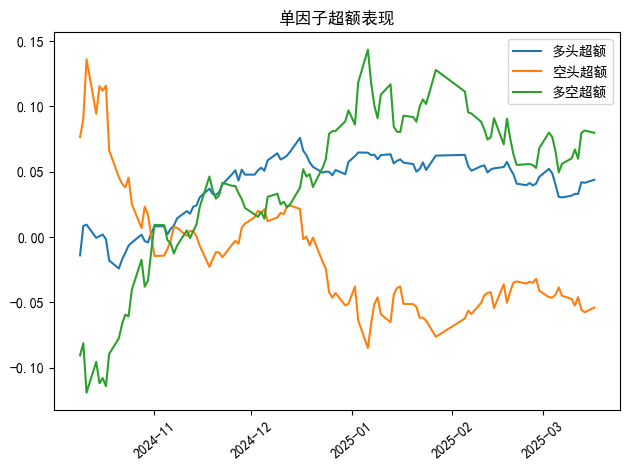

平均单边换手：0.546
年化交易成本:0.004 (未在超额中扣除)


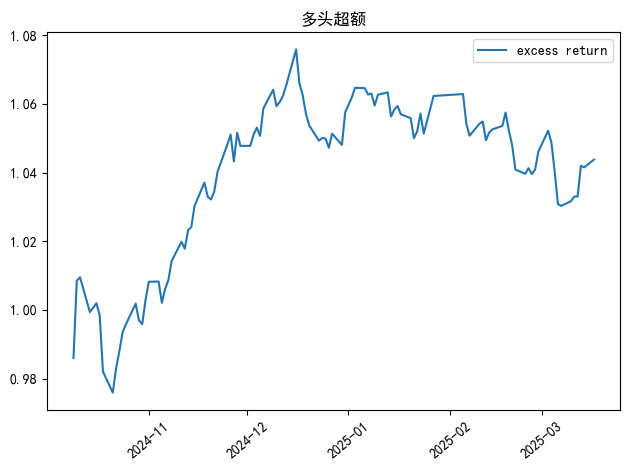

Rank IC: 6.65%
Rank ICIR: 0.82
t值: 2.00
年化收益率: 9.85%
年化波动率: 8.35%
信息比率: 1.18
夏普比率: 1.18
最大回撤: 3.36%


In [23]:
# 月均待著而救因子回测
pkg_path=r'C:\Users\ZHOU\Documents\2025CUHK\兴银\需要拷的数据\\'
res = backtest_stand(
    -monthly_mean,
    fre='month',
    stock_pool='888888',
    benchmark='b4',
    barra_neutral=True, # 中性化
    top=300,
    localdata_path=pkg_path+'packages/frdata',
    start='2024-10-01',
    end='2025-03-17'
)
# Rank IC
rank_ic = res['ic']['ic'].mean()
# Rank ICIR
rank_icir = res['ic']['ic'].mean() / res['ic']['ic'].std()
# t值
t_value = res['ic']['ic'].mean() / (res['ic']['ic'].std() / np.sqrt(res['ic']['ic'].count()))
perf = res['多空表现']['多头表现']  
annual_return = perf.loc['年化超额', 'mean']  # 年化收益率
annual_vol = perf.loc['波动率', 'mean']      # 年化波动率
info_ratio = perf.loc['信息比率', 'mean'] if '信息比率' in perf.index else annual_return / annual_vol
#win_rate = perf.loc['胜率', 'mean'] if '胜率' in perf.index else perf.loc['正月数', 'mean'] / perf.loc['总月数', 'mean']
max_drawdown = perf.loc['最大回撤', 'mean']
sharpe_ratio = annual_return / annual_vol
print(f"Rank IC: {rank_ic:.2%}")
print(f"Rank ICIR: {rank_icir:.2f}")
print(f"t值: {t_value:.2f}")
print(f"年化收益率: {annual_return:.2%}")
print(f"年化波动率: {annual_vol:.2%}")
print(f"信息比率: {info_ratio:.2f}")
print(f"夏普比率: {sharpe_ratio:.2f}")
#print(f"月度胜率: {win_rate:.2%}")
print(f"最大回撤: {max_drawdown:.2%}")

In [21]:
# 分析持仓集中度
import pandas as pd

# 多头持仓集中度（前10只股票权重）
long_concentration = res['多空持仓']['多头持仓'][0].head(10).sum()
print(f"多头前10只股票权重占比: {long_concentration:.2%}")

# 检查权重是否合理（应该接近100%）
total_weight = res['多空持仓']['多头持仓'][0].sum()
print(f"多头总权重: {total_weight:.2%}")

多头前10只股票权重占比: 5.44%
多头总权重: 100.00%


load data locally from 2009-01-05 to 2025-04-15
多头超额:
             2024    2025   mean
年化超额   0.3326  0.1791 0.2559
波动率     0.1250  0.0661 0.0956
最大回撤   0.0451  0.0116 0.0451
夏普率     2.6610  2.7095 2.6778
收益回撤比 7.3739 15.4125 5.6726
半波       0.0407  0.0153 0.0280
半夏普     8.1638 11.7109 9.1320


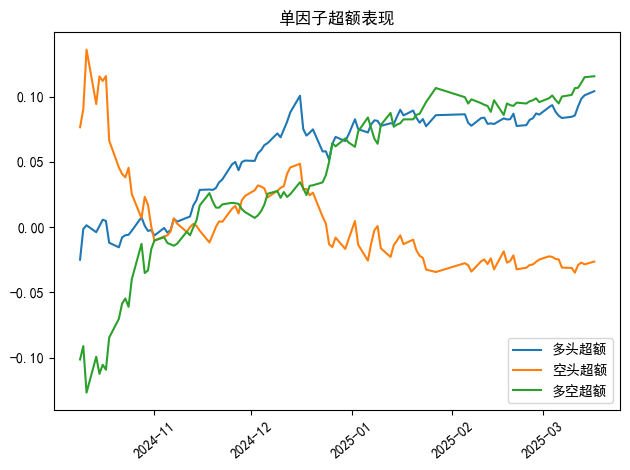

平均单边换手：0.827
年化交易成本:0.006 (未在超额中扣除)


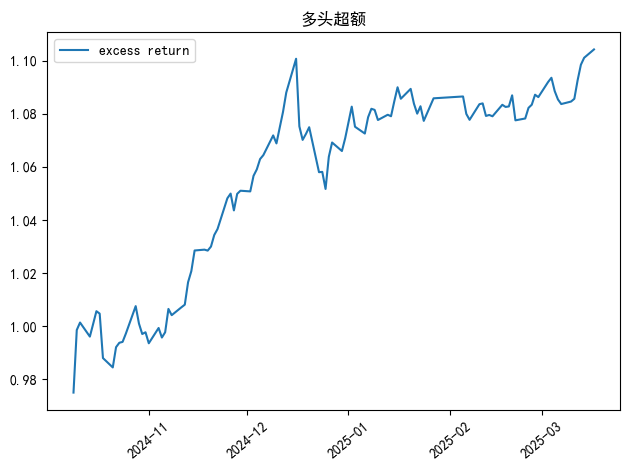

Rank IC: 6.27%
Rank ICIR: 1.02
t值: 2.50
年化收益率: 25.59%
年化波动率: 9.56%
信息比率: 2.68
夏普比率: 2.68
最大回撤: 4.51%


In [153]:
# 月稳待著而救因子回测
res = backtest_stand(
    -monthly_std,
    fre='month',
    stock_pool='888888',
    benchmark='b4',
    barra_neutral=True, # 中性化
    top=300,
    localdata_path=pkg_path+'packages/frdata',
    start='2024-09-31',
    end='2025-03-17'
)
# Rank IC
rank_ic = res['ic']['ic'].mean()
# Rank ICIR
rank_icir = res['ic']['ic'].mean() / res['ic']['ic'].std()
# t值
t_value = res['ic']['ic'].mean() / (res['ic']['ic'].std() / np.sqrt(res['ic']['ic'].count()))
perf = res['多空表现']['多头表现']  
annual_return = perf.loc['年化超额', 'mean']  # 年化收益率
annual_vol = perf.loc['波动率', 'mean']      # 年化波动率
info_ratio = perf.loc['信息比率', 'mean'] if '信息比率' in perf.index else annual_return / annual_vol
#win_rate = perf.loc['胜率', 'mean'] if '胜率' in perf.index else perf.loc['正月数', 'mean'] / perf.loc['总月数', 'mean']
max_drawdown = perf.loc['最大回撤', 'mean']
sharpe_ratio = annual_return / annual_vol
print(f"Rank IC: {rank_ic:.2%}")
print(f"Rank ICIR: {rank_icir:.2f}")
print(f"t值: {t_value:.2f}")
print(f"年化收益率: {annual_return:.2%}")
print(f"年化波动率: {annual_vol:.2%}")
print(f"信息比率: {info_ratio:.2f}")
print(f"夏普比率: {sharpe_ratio:.2f}")
#print(f"月度胜率: {win_rate:.2%}")
print(f"最大回撤: {max_drawdown:.2%}")

load data locally from 2009-01-05 to 2025-04-15
多头超额:
              2024    2025   mean
年化超额    0.3703 -0.0068 0.1817
波动率      0.1038  0.0649 0.0843
最大回撤    0.0316  0.0262 0.0316
夏普率      3.5685 -0.1043 2.1553
收益回撤比 11.7052 -0.2588 5.7456
半波        0.0297  0.0172 0.0235
半夏普     12.4529 -0.3926 7.7373


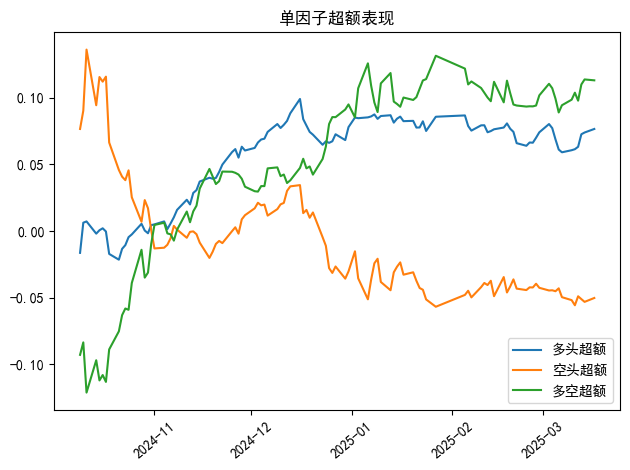

平均单边换手：0.639
年化交易成本:0.005 (未在超额中扣除)


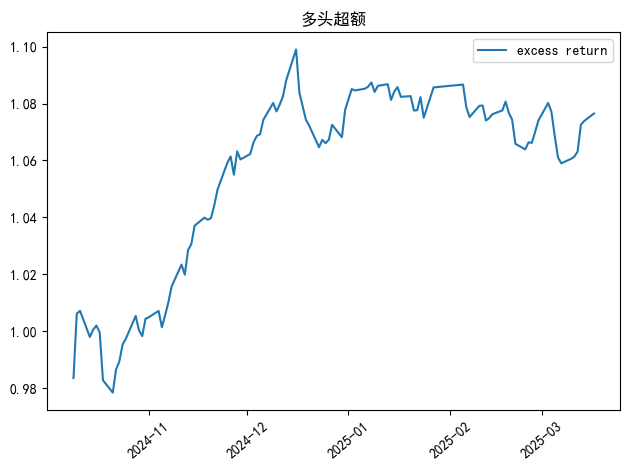

Rank IC: 6.80%
Rank ICIR: 0.94
t值: 2.30
年化收益率: 18.17%
年化波动率: 8.43%
信息比率: 2.16
最大回撤: 3.16%


In [17]:
# 待著而救因子回测
import numpy as np
res = backtest_stand(
    -final_factor,
    fre='month',
    stock_pool='888888',
    benchmark='b4',
    barra_neutral=True, # 中性化
    top=300,
    localdata_path=pkg_path+'packages/frdata',
    start='2024-09-31',
    end='2025-03-17'
)
# Rank IC
rank_ic = res['ic']['ic'].mean()
# Rank ICIR
rank_icir = res['ic']['ic'].mean() / res['ic']['ic'].std()
# t值
t_value = res['ic']['ic'].mean() / (res['ic']['ic'].std() / np.sqrt(res['ic']['ic'].count()))
perf = res['多空表现']['多头表现']  
annual_return = perf.loc['年化超额', 'mean']  # 年化收益率
annual_vol = perf.loc['波动率', 'mean']      # 年化波动率
info_ratio = perf.loc['信息比率', 'mean'] if '信息比率' in perf.index else annual_return / annual_vol
#win_rate = perf.loc['胜率', 'mean'] if '胜率' in perf.index else perf.loc['正月数', 'mean'] / perf.loc['总月数', 'mean']
max_drawdown = perf.loc['最大回撤', 'mean']
sharpe_ratio = annual_return / annual_vol
print(f"Rank IC: {rank_ic:.2%}")
print(f"Rank ICIR: {rank_icir:.2f}")
print(f"t值: {t_value:.2f}")
print(f"年化收益率: {annual_return:.2%}")
print(f"年化波动率: {annual_vol:.2%}")
print(f"信息比率: {info_ratio:.2f}")
#print(f"月度胜率: {win_rate:.2%}")
print(f"最大回撤: {max_drawdown:.2%}")

## 2.3 剥离其他风格因子影响后“待著而救”因子


可用的Barra因子: ['SIZE', 'SIZENL', 'EARNYILD', 'GROWTH', 'LEVERAGE', 'BTOP', 'LIQUIDTY', 'MOMENTUM', 'RESVOL', 'BETA']
共同时间点: 6个
时间范围: 2024-09-30 到 2025-02-28
市值      :   13.00% (基于6个时间点)
非线性市值   :    4.68% (基于6个时间点)
盈利      :  -15.55% (基于6个时间点)
成长      :   -0.82% (基于6个时间点)
杠杆      :   -5.03% (基于6个时间点)
分红      :  -26.51% (基于6个时间点)
流动性     :   47.55% (基于6个时间点)
反转      :   21.56% (基于6个时间点)
波动率     :   40.82% (基于6个时间点)
贝塔      :   13.54% (基于6个时间点)


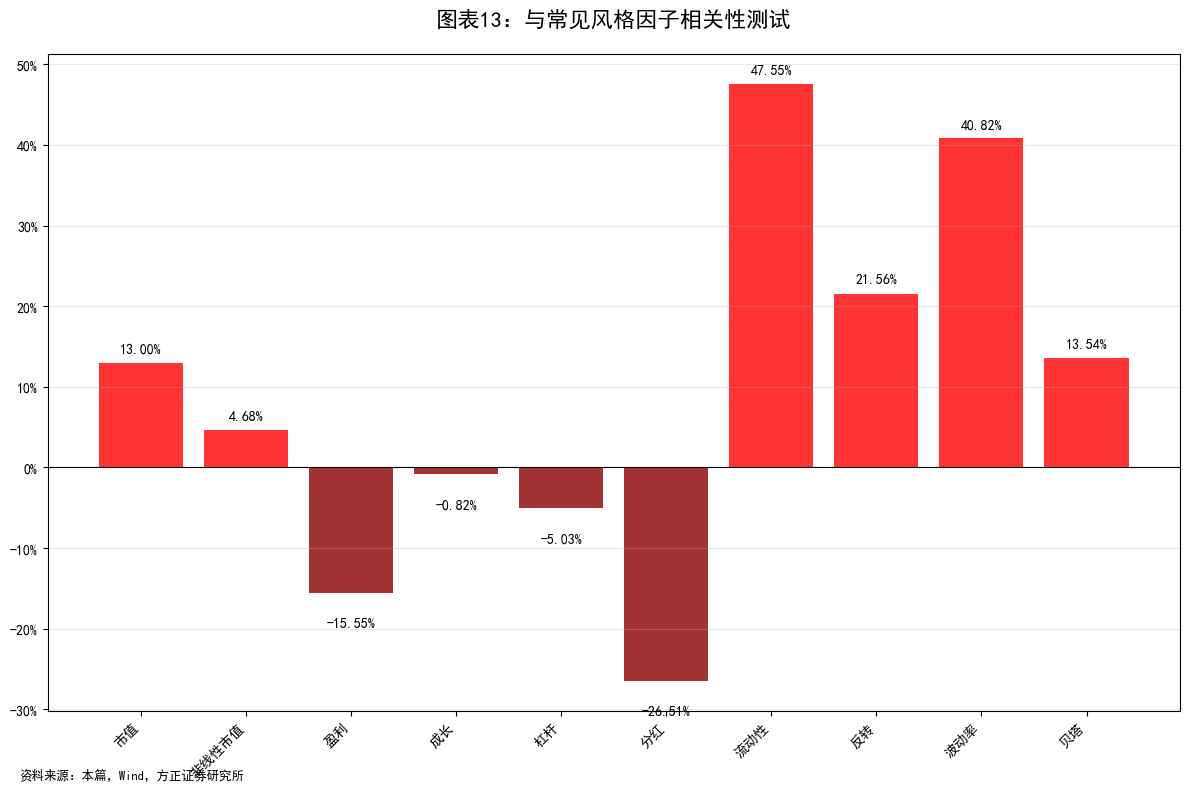

In [11]:
from scipy.stats import pearsonr
# =============================================================================
# Barra因子mapping
# =============================================================================

barra_factor_mapping = {
    'SIZE': '市值',
    'SIZENL': '非线性市值', 
    'EARNYILD': '盈利',
    'GROWTH': '成长',
    'LEVERAGE': '杠杆',
    'BTOP': '分红',
    'LIQUIDTY': '流动性',
    'MOMENTUM': '反转',
    'RESVOL': '波动率',
    'BETA': '贝塔'
}

print(f"可用的Barra因子: {list(barra_factor_mapping.keys())}")

# =============================================================================
# 计算相关性
# =============================================================================



def calculate_factor_correlation(final_factor, barra_data, factor_mapping):
    """
    计算final_factor与各Barra因子的相关性
    """
    correlations = {}
    p_values = {}
    
    # 获取共同的时间点
    common_dates = []
    for date in final_factor.index:
        if date in barra_data.index:
            common_dates.append(date)
    
    print(f"共同时间点: {len(common_dates)}个")
    print(f"时间范围: {min(common_dates)} 到 {max(common_dates)}")
    
    if len(common_dates) < 3:
        print("共同时间点太少，无法计算相关性")
        return None, None
    
    # 对每个Barra因子计算相关性
    for eng_name, chn_name in factor_mapping.items():
        factor_corrs = []
        
        # 对每个共同日期计算截面相关性
        for date in common_dates:
            try:
                # 获取final_factor在该日期的值
                final_scores = final_factor.loc[date].dropna()
                
                # 获取Barra因子在该日期的值
                if isinstance(barra_data.loc[date], dict):
                    # 如果barra_data是字典格式
                    barra_scores = pd.Series(barra_data.loc[date][eng_name])
                else:
                    # 如果barra_data是其他格式
                    barra_scores = barra_data.loc[date][eng_name]
                
                # 找到共同股票
                common_stocks = list(set(final_scores.index) & set(barra_scores.index))
                
                if len(common_stocks) > 50:  # 至少50只股票才计算相关性
                    final_aligned = final_scores.reindex(common_stocks).dropna()
                    barra_aligned = barra_scores.reindex(common_stocks).dropna()
                    
                    # 再次对齐（去除任一因子为空的股票）
                    final_common = final_aligned.reindex(barra_aligned.index).dropna()
                    barra_common = barra_aligned.reindex(final_common.index).dropna()
                    
                    if len(final_common) > 20:
                        corr, _ = pearsonr(final_common, barra_common)
                        if not np.isnan(corr):
                            factor_corrs.append(corr)
                            
            except Exception as e:
                print(f"计算{date}的{eng_name}相关性时出错: {e}")
                continue
        
        # 计算平均相关性
        if len(factor_corrs) > 0:
            avg_corr = np.mean(factor_corrs)
            correlations[chn_name] = avg_corr
            print(f"{chn_name:8s}: {avg_corr:8.2%} (基于{len(factor_corrs)}个时间点)")
        else:
            print(f"{chn_name}: 无法计算相关性")
    
    return correlations
# 向量化计算相关性
#def calculate_factor_correlation(final_factor, barra_data, factor_mapping):
# 
#    correlations = {}
#    
#    # 获取共同时间点
#    common_dates = final_factor.index.intersection(barra_data.index).tolist()
#    
#    print(f"共同时间点: {len(common_dates)}个")
#    if len(common_dates) < 3:
#        return None
#    
#    # 预处理final_factor数据
#    final_subset = final_factor.loc[common_dates]
#    
#    # 批量处理所有因子
#    factor_results = {}
#    
#    # 预先提取所有barra数据到字典
#    barra_dict = {}
#    for eng_name in factor_mapping.keys():
#        factor_data = []
#        valid_dates = []
#        
#        for date in common_dates:
#            try:
#                barra_date_data = barra_data.loc[date]
#                if eng_name in barra_date_data:
#                    if isinstance(barra_date_data[eng_name], dict):
#                        factor_data.append(pd.Series(barra_date_data[eng_name]))
#                    else:
#                        factor_data.append(barra_date_data[eng_name])
#                    valid_dates.append(date)
#            except:
#                continue
#        
#        if len(factor_data) > 0:
#            barra_dict[eng_name] = {
#                'data': pd.DataFrame(factor_data, index=valid_dates),
#                'dates': valid_dates
#            }
#    
#    # 向量化计算所有因子的相关性
#    for eng_name, chn_name in factor_mapping.items():
#        if eng_name not in barra_dict:
#            print(f"{chn_name}: 无数据")
#            continue
#            
#        try:
#            barra_df = barra_dict[eng_name]['data']
#            valid_dates = barra_dict[eng_name]['dates']
#            final_df = final_subset.reindex(valid_dates)
#            
#            # 使用pandas的向量化操作计算相关性
#            daily_corrs = []
#            
#            for i in range(len(valid_dates)):
#                final_day = final_df.iloc[i].dropna()
#                barra_day = barra_df.iloc[i].dropna()
#                
#                # 向量化找交集和对齐
#                common_idx = final_day.index.intersection(barra_day.index)
#                
#                if len(common_idx) > 50:
#                    # 向量化对齐和计算
#                    f_aligned = final_day.reindex(common_idx).dropna()
#                    b_aligned = barra_day.reindex(common_idx).dropna()
#                    
#                    common_final = f_aligned.index.intersection(b_aligned.index)
#                    
#                    if len(common_final) > 20:
#                        # 使用pandas内置的corr方法（向量化）
#                        corr = f_aligned.reindex(common_final).corr(b_aligned.reindex(common_final))
#                        if not np.isnan(corr):
#                            daily_corrs.append(corr)
#            
#            # 向量化计算平均值
#            if len(daily_corrs) > 0:
#                avg_corr = np.mean(daily_corrs)
#                correlations[chn_name] = avg_corr
#                print(f"{chn_name:12s}: {avg_corr:8.2%} (基于{len(daily_corrs)}个时间点)")
#            else:
#                print(f"{chn_name}: 无法计算相关性")
#                
#        except Exception as e:
#            print(f"计算{eng_name}时出错: {e}")
#            continue
#    
#    return correlations


# 计算相关性
correlations = calculate_factor_correlation(final_factor, barra_df_tl, barra_factor_mapping)

# =============================================================================
# 绘制相关性图表
# =============================================================================

if correlations and len(correlations) > 0:
    
    # 准备绘图数据
    factors = list(correlations.keys())
    corr_values = [correlations[factor] for factor in factors]
    
    # 创建颜色（正相关用红色，负相关用深红色）
    colors = ['red' if corr >= 0 else 'darkred' for corr in corr_values]
    
    # 绘制柱状图
    plt.figure(figsize=(12, 8))
    bars = plt.bar(range(len(factors)), corr_values, color=colors, alpha=0.8)
    
    # 设置图表属性
    plt.title('图表13：与常见风格因子相关性测试', fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('')
    plt.ylabel('')
    
    # 设置x轴标签
    plt.xticks(range(len(factors)), factors, rotation=45, ha='right')
    
    # 在柱子上添加数值标签
    for i, (bar, value) in enumerate(zip(bars, corr_values)):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., 
                height + (0.01 if height >= 0 else -0.03),
                f'{value:.2%}', 
                ha='center', va='bottom' if height >= 0 else 'top',
                fontweight='bold', fontsize=10)
    
    # 添加零线
    plt.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
    
    # 设置y轴格式
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.0%}'))
    
    # 调整布局
    plt.tight_layout()
    
    # 添加数据源说明
    plt.figtext(0.02, 0.02, '资料来源：本篇，Wind，方正证券研究所', 
               fontsize=9, ha='left')
    
    plt.grid(True, alpha=0.3, axis='y')
    plt.show()
    


In [13]:
from sklearn.linear_model import LinearRegression
import pandas as pd
import numpy as np
style_factors = ['SIZE', 'BETA', 'MOMENTUM', 'EARNYILD', 'GROWTH', 'BTOP', 'LEVERAGE', 'LIQUIDTY']

print(f"📊 将中性化的风格因子: {style_factors}")

# =============================================================================
#构建风格因子中性化函数
# =============================================================================

def neutralize_factor_against_styles(target_factor, barra_data, style_factors, method='regression'):
    """
    风格因子中性化处理
    
    Parameters:
    - target_factor: 目标因子 (DataFrame)
    - barra_data: Barra风格因子数据 
    - style_factors: 要中性化的风格因子列表
    - method: 中性化方法 ('regression', 'orthogonal')
    
    Returns:
    - neutralized_factor: 中性化后的因子
    - regression_stats: 回归统计信息
    """
    
    neutralized_factor = target_factor.copy()
    regression_stats = {}
    
    print(f"\n开始{method}中性化处理...")
    
    # 获取共同日期
    common_dates = target_factor.index.intersection(barra_data.index).tolist()
    print(f"处理日期数量: {len(common_dates)}")
    
    for date in common_dates:
        try:
            # 获取目标因子数据
            target_scores = target_factor.loc[date].dropna()
            
            # 获取风格因子数据
            barra_date_data = barra_data.loc[date]
            
            # 构建风格因子矩阵
            style_matrix = []
            stock_intersection = set(target_scores.index)
            
            for style_factor in style_factors:
                if style_factor in barra_date_data:
                    if isinstance(barra_date_data[style_factor], dict):
                        style_data = pd.Series(barra_date_data[style_factor])
                    else:
                        style_data = barra_date_data[style_factor]
                    
                    # 找到交集股票
                    stock_intersection = stock_intersection.intersection(set(style_data.index))
                    style_matrix.append(style_data)
            
            if len(stock_intersection) < 100:  # 至少100只股票
                print(f"{date}: 股票数量不足({len(stock_intersection)})")
                continue
            
            # 对齐数据
            common_stocks = list(stock_intersection)
            y = target_scores.reindex(common_stocks).dropna()
            
            X_data = []
            for style_data in style_matrix:
                aligned_style = style_data.reindex(common_stocks)
                X_data.append(aligned_style)
            
            if len(X_data) == 0:
                continue
                
            X = pd.DataFrame(X_data, index=style_factors[:len(X_data)]).T
            
            # 再次对齐，去除任何NaN
            valid_stocks = y.index.intersection(X.index)
            y_clean = y.reindex(valid_stocks).dropna()
            X_clean = X.reindex(valid_stocks).dropna()
            
            # 最终对齐
            final_stocks = y_clean.index.intersection(X_clean.index)
            if len(final_stocks) < 50:
                continue
                
            y_final = y_clean.reindex(final_stocks)
            X_final = X_clean.reindex(final_stocks)
            
            if method == 'regression':
                # 线性回归中性化
                reg = LinearRegression()
                reg.fit(X_final, y_final)
                
                # 计算残差
                residuals = y_final - reg.predict(X_final)
                
                # 保存回归统计
                r_squared = reg.score(X_final, y_final)
                regression_stats[date] = {
                    'r_squared': r_squared,
                    'coefficients': dict(zip(X_final.columns, reg.coef_)),
                    'intercept': reg.intercept_,
                    'n_stocks': len(final_stocks)
                }
                
                # 更新中性化因子
                neutralized_factor.loc[date, final_stocks] = residuals
                
            elif method == 'orthogonal':
                # 施密特正交化
                from sklearn.decomposition import PCA
                
                # 标准化
                scaler = StandardScaler()
                X_scaled = scaler.fit_transform(X_final)
                y_scaled = scaler.fit_transform(y_final.values.reshape(-1, 1)).flatten()
                
                # 对y关于X进行正交化
                Q, R = np.linalg.qr(np.column_stack([X_scaled, y_scaled.reshape(-1, 1)]))
                orthogonal_y = Q[:, -1] * R[-1, -1]
                
                neutralized_factor.loc[date, final_stocks] = orthogonal_y
                
        except Exception as e:
            print(f"⚠️ 处理{date}时出错: {e}")
            continue
    
    return neutralized_factor, regression_stats

# =============================================================================
# 第3步：执行中性化处理
# =============================================================================

# 对final_factor进行中性化
neutralized_factor, reg_stats = neutralize_factor_against_styles(
    final_factor, barra_df_tl, style_factors, method='regression'
)

print("✅ 风格因子中性化完成")

📊 将中性化的风格因子: ['SIZE', 'BETA', 'MOMENTUM', 'EARNYILD', 'GROWTH', 'BTOP', 'LEVERAGE', 'LIQUIDTY']

开始regression中性化处理...
处理日期数量: 6
✅ 风格因子中性化完成


load data locally from 2009-01-05 to 2025-04-15
多头超额:
             2024   2025   mean
年化超额   0.1660 0.0173 0.0917
波动率     0.1173 0.0636 0.0905
最大回撤   0.0378 0.0238 0.0378
夏普率     1.4150 0.2728 1.0135
收益回撤比 4.3881 0.7275 2.4233
半波       0.0382 0.0164 0.0273
半夏普     4.3484 1.0550 3.3568


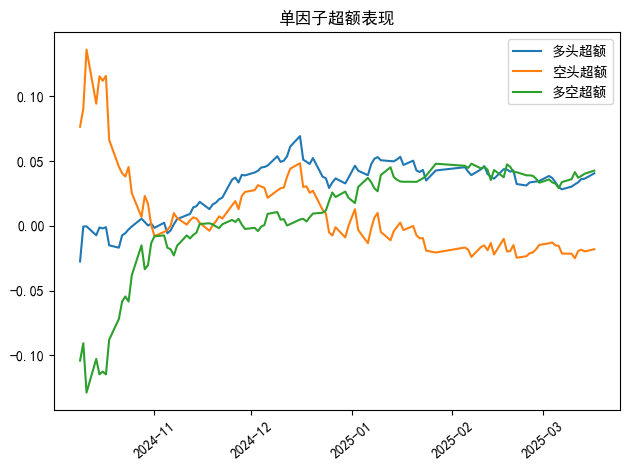

平均单边换手：0.658
年化交易成本:0.005 (未在超额中扣除)


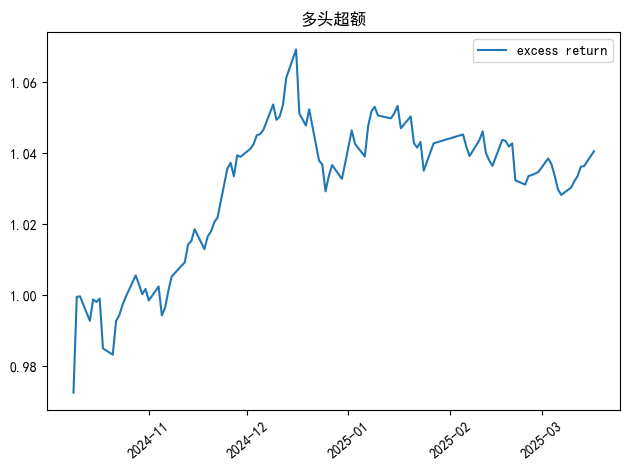

Rank IC: 3.56%
Rank ICIR: 1.08
t值: 2.66
年化收益率: 9.17%
年化波动率: 9.05%
信息比率: 1.01
最大回撤: 3.78%


In [15]:
# 中性化因子回测
pkg_path=r'C:\Users\ZHOU\Documents\2025CUHK\兴银\需要拷的数据\\'
import numpy as np
res = backtest_stand(
    -neutralized_factor,
    fre='month',
    stock_pool='888888',
    benchmark='b4',
    barra_neutral=True, # 中性化
    top=300,
    localdata_path=pkg_path+'packages/frdata',
    start='2024-09-31',
    end='2025-03-17'
)
# Rank IC
rank_ic = res['ic']['ic'].mean()
# Rank ICIR
rank_icir = res['ic']['ic'].mean() / res['ic']['ic'].std()
# t值
t_value = res['ic']['ic'].mean() / (res['ic']['ic'].std() / np.sqrt(res['ic']['ic'].count()))
perf = res['多空表现']['多头表现']  
annual_return = perf.loc['年化超额', 'mean']  # 年化收益率
annual_vol = perf.loc['波动率', 'mean']      # 年化波动率
info_ratio = perf.loc['信息比率', 'mean'] if '信息比率' in perf.index else annual_return / annual_vol
#win_rate = perf.loc['胜率', 'mean'] if '胜率' in perf.index else perf.loc['正月数', 'mean'] / perf.loc['总月数', 'mean']
max_drawdown = perf.loc['最大回撤', 'mean']
sharpe_ratio = annual_return / annual_vol
print(f"Rank IC: {rank_ic:.2%}")
print(f"Rank ICIR: {rank_icir:.2f}")
print(f"t值: {t_value:.2f}")
print(f"年化收益率: {annual_return:.2%}")
print(f"年化波动率: {annual_vol:.2%}")
print(f"信息比率: {info_ratio:.2f}")
#print(f"月度胜率: {win_rate:.2%}")
print(f"最大回撤: {max_drawdown:.2%}")

## 2.4 “待著而救”因子在不同样本空间下的表现


不同股票池回测结果

正在回测 沪深300 (000300)...
load data locally from 2009-01-05 to 2025-04-15
多头超额:
             2024    2025   mean
年化超额   0.1712 -0.0350 0.0681
波动率     0.0778  0.0507 0.0642
最大回撤   0.0172  0.0152 0.0172
夏普率     2.2003 -0.6913 1.0600
收益回撤比 9.9664 -2.2973 3.9638
半波       0.0230  0.0142 0.0186
半夏普     7.4501 -2.4714 3.6654


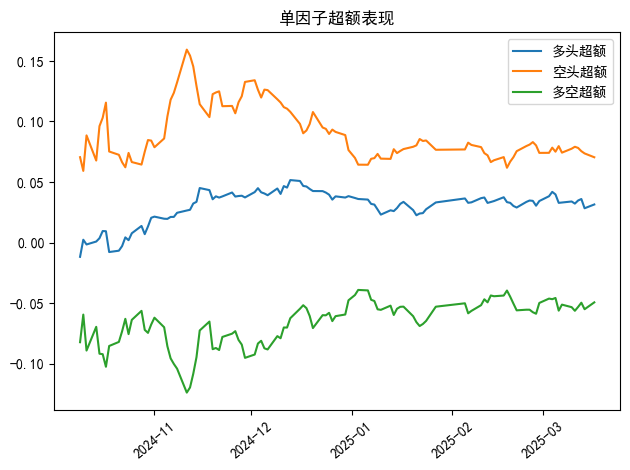

平均单边换手：0.444
年化交易成本:0.003 (未在超额中扣除)


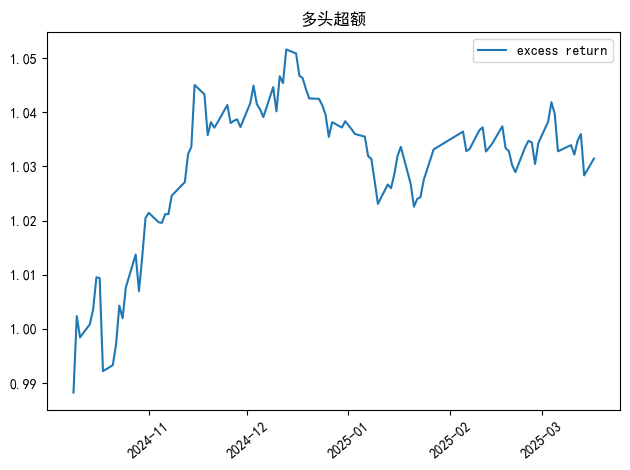

✅ 沪深300 回测完成
   年化超额收益: 6.81%
   信息比率: 1.06
   Rank IC: 0.045

正在回测 中证500 (000905)...
load data locally from 2009-01-05 to 2025-04-15
多头超额:
             2024    2025   mean
年化超额   0.1265 -0.1005 0.0130
波动率     0.0656  0.0576 0.0616
最大回撤   0.0216  0.0390 0.0390
夏普率     1.9276 -1.7446 0.2109
收益回撤比 5.8443 -2.5736 0.3328
半波       0.0175  0.0158 0.0166
半夏普     7.2090 -6.3788 0.7806


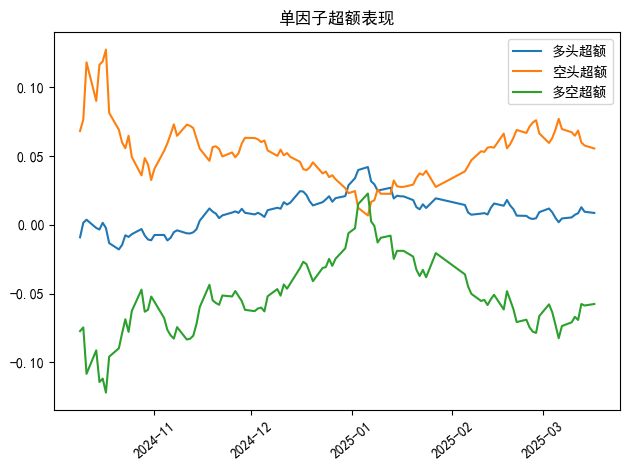

平均单边换手：0.396
年化交易成本:0.003 (未在超额中扣除)


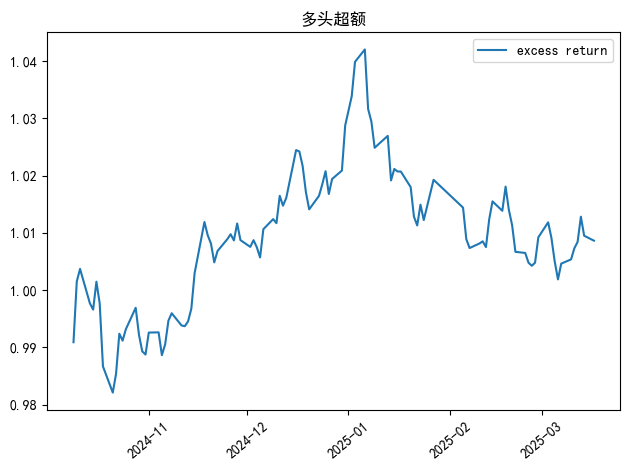

✅ 中证500 回测完成
   年化超额收益: 1.30%
   信息比率: 0.21
   Rank IC: 0.053

正在回测 中证1000 (1000)...
load data locally from 2009-01-05 to 2025-04-15
多头超额:
             2024    2025    mean
年化超额   0.1239 -0.1561 -0.0161
波动率     0.0907  0.0821  0.0864
最大回撤   0.0436  0.0610  0.0610
夏普率     1.3664 -1.9024 -0.1861
收益回撤比 2.8417 -2.5580 -0.2635
半波       0.0260  0.0225  0.0243
半夏普     4.7612 -6.9464 -0.6629


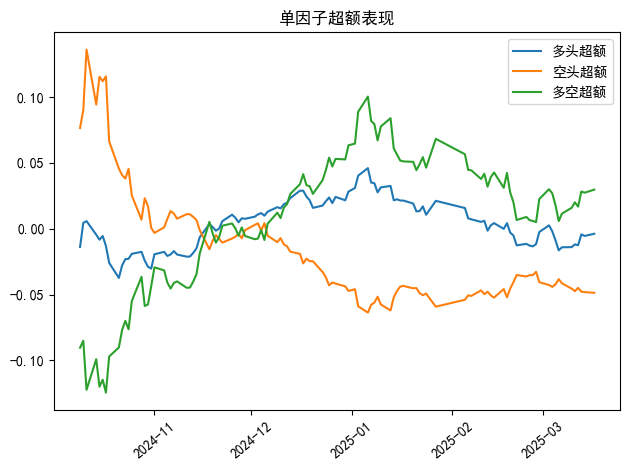

平均单边换手：0.489
年化交易成本:0.004 (未在超额中扣除)


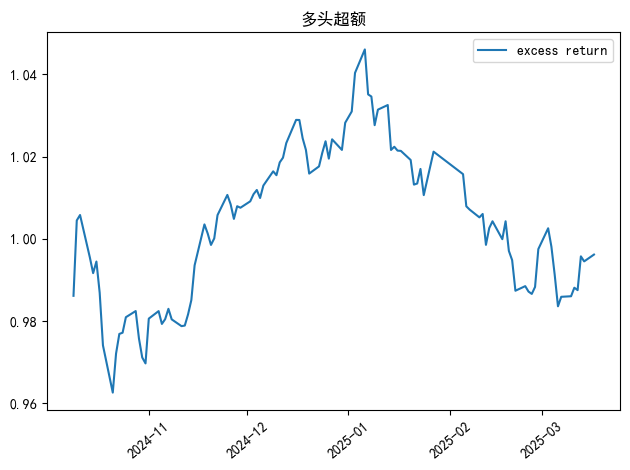

✅ 中证1000 回测完成
   年化超额收益: -1.61%
   信息比率: -0.19
   Rank IC: 0.058

正在回测 全A股 (888888)...
load data locally from 2009-01-05 to 2025-04-15
多头超额:
              2024    2025    mean
年化超额    0.5862  0.2169  0.4015
波动率      0.1408  0.0643  0.1025
最大回撤    0.0470  0.0112  0.0470
夏普率      4.1637  3.3741  3.9162
收益回撤比 12.4600 19.4029  8.5348
半波        0.0445  0.0140  0.0293
半夏普     13.1635 15.4800 13.7179


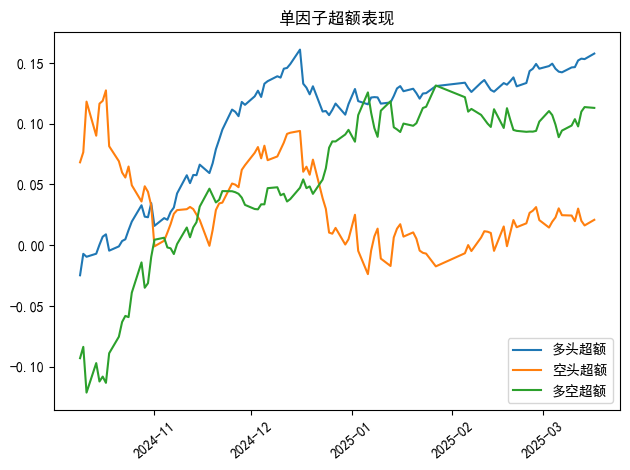

平均单边换手：0.639
年化交易成本:0.005 (未在超额中扣除)


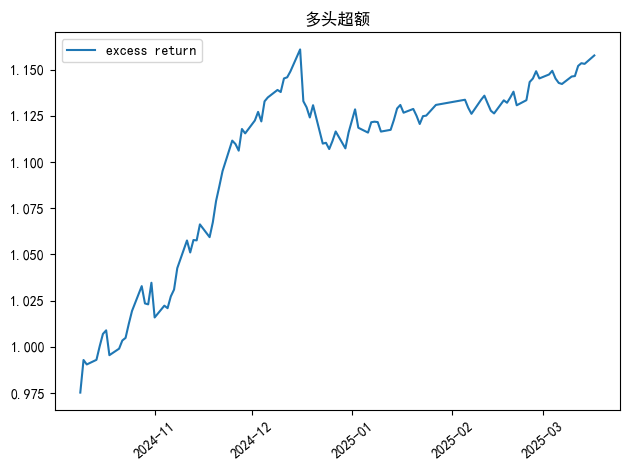

✅ 全A股 回测完成
   年化超额收益: 40.15%
   信息比率: 3.92
   Rank IC: 0.068

回测结果汇总
     股票池    代码  年化超额收益  年化波动率  信息比率  最大回撤  Rank IC  \
0   沪深300  000300        0.0681      0.0642    1.0600    0.0172   0.0446   
1   中证500  000905        0.0130      0.0616    0.2109    0.0390   0.0526   
2  中证1000    1000       -0.0161      0.0864   -0.1861    0.0610   0.0584   
3     全A股  888888        0.4015      0.1025    3.9162    0.0470   0.0680   

    ICIR  
0 0.3699  
1 0.3815  
2 0.5818  
3 0.9404  


In [29]:
# 不同股票池回测代码
import pandas as pd
import numpy as np

# 指数池与benchmark、top的对应关系
pool_benchmark_top_map = {
    '000300': {'benchmark': 'b1', 'top': 100},   # 沪深300
    '000905': {'benchmark': 'b2', 'top': 300},   # 中证500
    '1000':   {'benchmark': 'b4', 'top': 300},   # 中证1000
    '1800':   {'benchmark': 'b3', 'top': 500},   # 800+1000
    '2000':   {'benchmark': 'b6', 'top': 500},   # 国证2000
    '888888': {'benchmark': 'b2', 'top': 300},   # 全A，默认
}

def get_benchmark_and_top(pool_code):
    """获取对应的基准和选股数量"""
    if pool_code.startswith('TOP'):
        return 'b2', int(pool_code[3:]) 
    if pool_code.startswith('TPCT'):
        return 'b2', None               
    return (
        pool_benchmark_top_map.get(pool_code, {'benchmark': 'b2', 'top': 300})['benchmark'],
        pool_benchmark_top_map.get(pool_code, {'benchmark': 'b2', 'top': 300})['top']
    )

# 回测参数设置
start_date = '2024-10-01'  
end_date = '2025-03-17'

# 股票池配置
pools_config = [
    ('000300', '沪深300'),
    ('000905', '中证500'), 
    ('1000', '中证1000'),
    ('888888', '全A股')  # 添加全A作为对比
]


results = []  
detailed_results = []  

print("="*60)
print("不同股票池回测结果")
print("="*60)

for pool_code, pool_name in pools_config:
    print(f"\n正在回测 {pool_name} ({pool_code})...")
    
    # 获取对应的基准和选股数量
    benchmark, top = get_benchmark_and_top(pool_code)
    
    # 执行回测
    res = backtest_stand(
        -final_factor, 
        start=start_date,
        end=end_date,
        benchmark=benchmark,
        stock_pool=pool_code,
        barra_neutral=True,
        fre='month',
        top=top,
        localdata_path=pkg_path+'packages/frdata'
    )
    
    # 提取关键指标
    performance_metrics = {
        '股票池': pool_name,  # 添加股票池名称
        '代码': pool_code,    # 添加代码
        '年化超额收益': res['多空表现']['多头表现'].loc['年化超额', 'mean'],
        '年化波动率': res['多空表现']['多头表现'].loc['波动率', 'mean'],
        '信息比率': res['多空表现']['多头表现'].loc['年化超额', 'mean'] / res['多空表现']['多头表现'].loc['波动率', 'mean'],
        '最大回撤': res['多空表现']['多头表现'].loc['最大回撤', 'mean'],
        'Rank IC': res['ic']['ic'].mean(),
        'ICIR': res['ic']['ic'].mean() / res['ic']['ic'].std()
    }
    
    # 存储结果 - 改为append到list
    results.append(performance_metrics)
    detailed_results.append((pool_name, res))  # 存储为tuple
    
    # 打印结果
    print(f"{pool_name} 回测完成")
    print(f"   年化超额收益: {performance_metrics['年化超额收益']:.2%}")
    print(f"   信息比率: {performance_metrics['信息比率']:.2f}")
    print(f"   Rank IC: {performance_metrics['Rank IC']:.3f}")

# 将results转换为DataFrame便于查看
results_df = pd.DataFrame(results)
print("\n" + "="*60)
print("回测结果汇总")
print("="*60)
print(results_df)

In [121]:
final_factor

stock_code,000001,000002,000004,000006,000007,000008,000009,000010,000011,000012,000014,000016,000017,000019,000020,000021,000025,000026,000027,000028,...,688758,688766,688767,688768,688772,688776,688777,688778,688779,688786,688787,688788,688789,688793,688798,688799,688800,688819,688981,689009
_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-09-30,1.4379,1.6077,2.1198,1.8163,1.3150,1.0713,1.7365,1.2122,1.9116,1.2038,1.7025,3.4078,1.3285,1.4215,2.6913,1.5774,2.9531,1.2558,1.3159,1.5875,...,nan,1.7068,1.1295,1.2875,1.3845,1.4265,1.7847,1.6548,1.6202,1.1685,1.4055,1.4413,1.5349,1.3152,1.3858,1.1733,1.3325,1.5208,1.7829,1.8856
2024-10-31,1.5802,1.9565,2.5582,2.0468,1.2518,1.2109,1.5252,1.4040,1.8197,1.3828,1.8767,1.7903,1.3819,1.4529,1.8832,2.1787,2.7368,1.6133,1.6162,1.4988,...,nan,1.6351,1.0623,1.2973,1.7320,1.3454,1.8791,1.5890,1.7175,1.1646,1.7491,1.1855,1.4906,1.5791,1.5044,1.4878,1.6714,1.4909,6.3311,1.6979
2024-11-29,1.6090,1.6911,2.1822,2.4815,2.0213,1.3575,1.6042,1.6915,1.5106,2.1476,1.6908,2.6100,1.7551,1.3101,1.3923,2.1800,1.6623,1.4061,1.2938,1.3660,...,nan,1.6596,1.4559,1.4463,1.4201,1.4038,1.8022,1.7463,1.7013,1.3596,1.7602,1.3154,1.4280,1.2150,1.8235,1.3259,1.8150,1.4285,2.4956,1.6476
2024-12-31,1.6063,1.6672,1.8802,1.7060,1.5383,2.0421,1.2915,1.8066,1.6080,1.1388,1.3954,2.2556,1.6402,1.2934,1.4855,1.6978,1.5074,1.4511,1.1786,1.3351,...,nan,1.9157,1.3628,1.4751,1.5099,1.4144,1.9525,1.7286,1.3674,1.2487,2.0709,1.2855,1.3344,2.0820,1.7350,1.2878,1.7967,1.3014,1.9232,1.8425
2025-01-27,1.5602,1.4474,1.6377,2.0194,1.1968,1.3053,1.3202,1.4107,1.2544,1.0761,1.5317,2.2273,1.4581,1.2251,1.3872,1.7221,1.3004,1.3694,1.1771,1.3405,...,2.0657,1.8861,1.3368,1.4370,1.3760,1.5525,1.6273,1.5539,1.2489,1.3543,2.0570,1.1740,1.5020,1.2885,1.5616,1.1239,1.9401,1.2587,1.9391,1.9140
2025-02-28,1.4544,1.7946,1.6411,1.4132,1.2845,1.9455,1.6778,1.1241,1.4141,1.0337,1.3004,2.1537,1.2530,1.1307,1.3586,1.8301,1.9185,1.5985,1.0999,1.2905,...,1.4749,1.6695,1.3115,1.4396,1.4737,1.5992,1.8951,1.9032,1.3111,1.3070,1.9485,1.4550,1.4750,1.3497,1.7341,1.1361,1.7331,1.4412,1.8026,1.7514


✅ 沪深300 最终累计收益: 0.95
✅ 中证500 最终累计收益: 0.94
✅ 中证1000 最终累计收益: 1.03
✅ 全A股 最终累计收益: 1.11


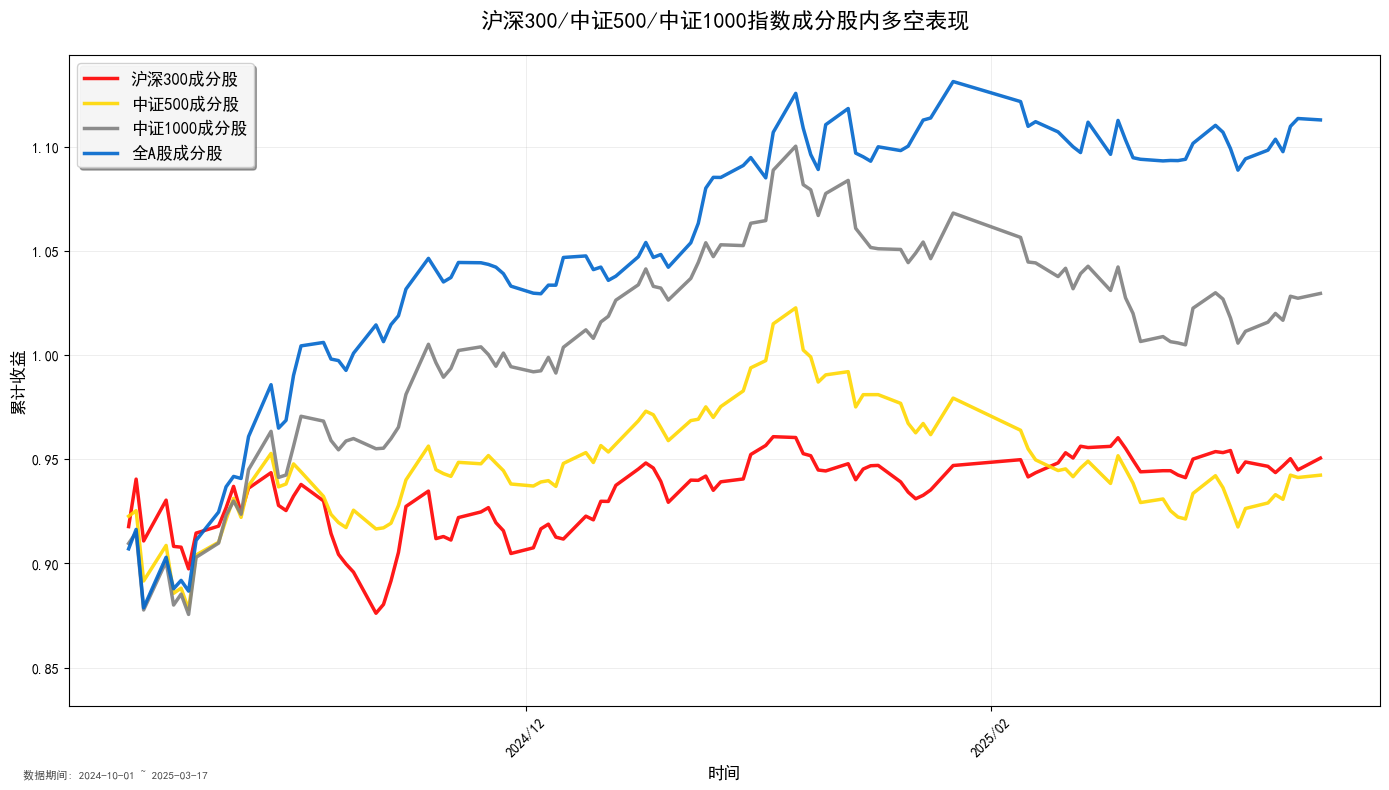

In [48]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei', 'Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False

def plot_portfolio_comparison(detailed_results_list, start_date, end_date):
    """绘制不同股票池的多空表现对比图 - 适配list格式，修复时间索引问题"""
    
    # 创建图表
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # 定义颜色和样式
    colors = {
        '沪深300': '#FF0000',    # 红色
        '中证500': '#FFD700',    # 金黄色  
        '中证1000': '#808080',   # 灰色
        '全A股': '#0066CC'       # 蓝色，如果需要的话
    }
    
    line_width = 2.5
    
    # 绘制每个股票池的累计收益曲线
    for pool_name, res in detailed_results_list:  # 直接遍历list of tuples
        if pool_name in colors:  # 只绘制指定的指数
            try:
                # 获取多空超额收益序列
                longshort_returns = res['多空收益']['多空超额']

            
                # 转换为累计收益（从1开始）
                cumulative_returns = (1 + longshort_returns).cumprod()
                
                #print(f"   累计收益范围: {cumulative_returns.min():.3f} ~ {cumulative_returns.max():.3f}")
                
                # 绘制线条
                ax.plot(
                    cumulative_returns.index, 
                    cumulative_returns.values,
                    color=colors[pool_name],
                    linewidth=line_width,
                    label=f'{pool_name}成分股',
                    alpha=0.9
                )
                
                print(f"{pool_name} 最终累计收益: {cumulative_returns.iloc[-1]:.2f}")
                
            except Exception as e:
                print(f"{pool_name} 绘制失败: {e}")
                import traceback
                traceback.print_exc()
    
    # 设置图表样式
    ax.set_title('沪深300/中证500/中证1000指数成分股内多空表现', 
                fontsize=16, fontweight='bold', pad=20)
    
    # 设置坐标轴
    ax.set_xlabel('时间', fontsize=12)
    ax.set_ylabel('累计收益', fontsize=12)
    
    # 设置网格
    ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
    ax.set_axisbelow(True)
    
    # 设置图例
    legend = ax.legend(
        loc='upper left',
        fontsize=12,
        frameon=True,
        fancybox=True,
        shadow=True,
        framealpha=0.9
    )
    
    # 设置坐标轴格式
    ax.tick_params(axis='both', which='major', labelsize=10)
    
    # 格式化x轴日期显示 - 只有在有有效数据时才设置
    if len(ax.get_lines()) > 0:  # 确保有绘制的线条
        try:
            # 设置日期格式
            ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))  # 每2个月显示一次
            ax.xaxis.set_major_formatter(DateFormatter('%Y/%m'))
            
            # 旋转x轴标签
            plt.xticks(rotation=45)
            
            #print("时间轴格式设置完成")
            
        except Exception as e:
            print(f"时间轴设置失败: {e}")
    
    # 设置y轴从合适的位置开始
    try:
        y_min = min([min((1 + res['多空收益']['多空超额']).cumprod()) 
                    for pool_name, res in detailed_results_list 
                    if pool_name in colors])
        ax.set_ylim(bottom=max(0, y_min * 0.95))
    except:
        print("y轴范围设置失败，使用默认设置")
    
    # 调整布局
    plt.tight_layout()
    
    # 添加数据源注释
    plt.figtext(0.02, 0.02, f'数据期间: {start_date} ~ {end_date}',
                fontsize=8, style='italic', alpha=0.7)
    
    # 显示图表
    plt.show()
    


# 调用绘图函数
plot_portfolio_comparison(detailed_results, start_date, end_date) 

✅ 沪深300 最终累计收益: 1.03
✅ 中证500 最终累计收益: 1.01
✅ 中证1000 最终累计收益: 1.00
✅ 全A股 最终累计收益: 1.16


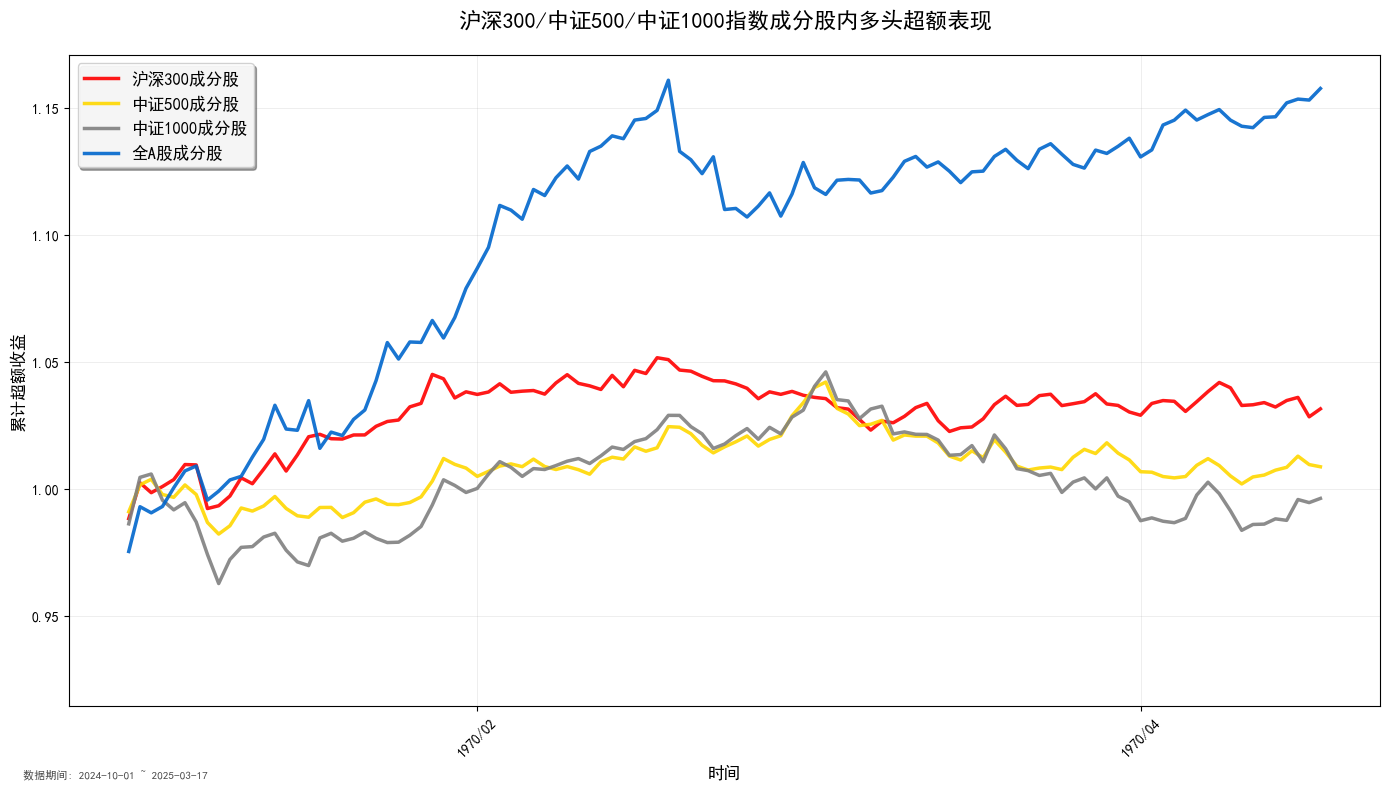

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei', 'Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False

def plot_portfolio_comparison(detailed_results_list, start_date, end_date):
    """绘制不同股票池的多空表现对比图 - 适配list格式，修复时间索引问题"""
    
    # 创建图表
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # 定义颜色和样式
    colors = {
        '沪深300': '#FF0000',    # 红色
        '中证500': '#FFD700',    # 金黄色  
        '中证1000': '#808080',   # 灰色
        '全A股': '#0066CC'       # 蓝色，如果需要的话
    }
    
    line_width = 2.5
    
    # 绘制每个股票池的累计收益曲线
    for pool_name, res in detailed_results_list:  # 直接遍历list of tuples
        if pool_name in colors:  # 只绘制指定的指数
            try:
                # 获取多空超额收益序列
                longshort_returns = res['多空收益']['多头超额']

            
                # 转换为累计收益（从1开始）
                cumulative_returns = (1 + longshort_returns).cumprod()
                
                #print(f"   累计收益范围: {cumulative_returns.min():.3f} ~ {cumulative_returns.max():.3f}")
                
                # 绘制线条
                ax.plot(
                    cumulative_returns.index, 
                    cumulative_returns.values,
                    color=colors[pool_name],
                    linewidth=line_width,
                    label=f'{pool_name}成分股',
                    alpha=0.9
                )
                
                print(f"{pool_name} 最终累计收益: {cumulative_returns.iloc[-1]:.2f}")
                
            except Exception as e:
                print(f"{pool_name} 绘制失败: {e}")
                import traceback
                traceback.print_exc()
    
    # 设置图表样式
    ax.set_title('沪深300/中证500/中证1000指数成分股内多头超额表现', 
                fontsize=16, fontweight='bold', pad=20)
    
    # 设置坐标轴
    ax.set_xlabel('时间', fontsize=12)
    ax.set_ylabel('累计超额收益', fontsize=12)
    
    # 设置网格
    ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
    ax.set_axisbelow(True)
    
    # 设置图例
    legend = ax.legend(
        loc='upper left',
        fontsize=12,
        frameon=True,
        fancybox=True,
        shadow=True,
        framealpha=0.9
    )
    
    # 设置坐标轴格式
    ax.tick_params(axis='both', which='major', labelsize=10)
    
    # 格式化x轴日期显示 - 只有在有有效数据时才设置
    if len(ax.get_lines()) > 0:  # 确保有绘制的线条
        try:
            # 设置日期格式
            ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))  # 每2个月显示一次
            ax.xaxis.set_major_formatter(DateFormatter('%Y/%m'))
            
            # 旋转x轴标签
            plt.xticks(rotation=45)
            
            #print("时间轴格式设置完成")
            
        except Exception as e:
            print(f"时间轴设置失败: {e}")
    
    # 设置y轴从合适的位置开始
    try:
        y_min = min([min((1 + res['多空收益']['多头超额']).cumprod()) 
                    for pool_name, res in detailed_results_list 
                    if pool_name in colors])
        ax.set_ylim(bottom=max(0, y_min * 0.95))
    except:
        print("y轴范围设置失败，使用默认设置")
    
    # 调整布局
    plt.tight_layout()
    
    # 添加数据源注释
    plt.figtext(0.02, 0.02, f'数据期间: {start_date} ~ {end_date}',
                fontsize=8, style='italic', alpha=0.7)
    
    # 显示图表
    plt.show()
    


# 调用绘图函数
plot_portfolio_comparison(detailed_results, start_date, end_date) 

## 2.5 指数增强

### - 单天指数增强

In [8]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

print("🚀 开始指数增强分析")

# =============================================================================
# 第1步：准备数据
# =============================================================================
print("\n第1步：准备数据")

# 确保final_factor存在
if 'final_factor' not in globals():
    print("未找到final_factor，请先构建因子")
else:
    print(f"final_factor数据: {final_factor.shape}")
    print(f"   时间范围: {final_factor.index[0]} ~ {final_factor.index[-1]}")

# 获取最近可用的日期
factor_date = final_factor.index[-1]  # 使用最新的因子数据
print(f"使用因子数据日期: {factor_date}")

# 获取因子得分
factor_scores = final_factor.loc[factor_date].dropna()
print(f"有效股票数量: {len(factor_scores)}")

🚀 开始指数增强分析

第1步：准备数据
final_factor数据: (6, 5143)
   时间范围: 2024-09-30 ~ 2025-02-28
使用因子数据日期: 2025-02-28
有效股票数量: 5130


In [9]:
# =============================================================================
# 第2步：获取指数成分股权重
# =============================================================================
print("\n第2步：获取指数权重")

# 读取指数成分
with open(r'C:\Users\ZHOU\Documents\2025CUHK\兴银\需要拷的数据\packages\frdata\index_dict.pkl', 'rb') as f:
    index_dict = pickle.load(f)  # dict

# 找到最近的指数权重数据
available_index_dates = [d for d in index_dict['index']['_id'] if d <= factor_date]
index_date = max(available_index_dates)
print(f"使用指数权重日期: {index_date}")

# 获取对应日期的权重数据
# 找到该日期在DataFrame中的行
date_mask = index_dict['index']['_id'] == index_date
index_weights_data = index_dict['index'].loc[date_mask, 'indexComponentsWeight'].iloc[0]

print(f"可用指数: {list(index_weights_data.keys())}")

# 获取三大指数的成分股权重
index_names = ['000300', '000905', '000852']  # 沪深300, 中证500, 中证1000
index_weights = {}

for idx_name in index_names:
    if idx_name in index_weights_data:  # 检查指数是否存在于权重数据中
        weights_dict = index_weights_data[idx_name]  # 获取该指数的权重字典
        weights = pd.Series(weights_dict)  # 转换为Series
        weights = weights / weights.sum()  # 归一化
        index_weights[idx_name] = weights
        print(f"{idx_name} 成分股数量: {len(weights)}")
    else:
        print(f"{idx_name} 不存在于数据中")


第2步：获取指数权重
使用指数权重日期: 2025-02-28
可用指数: ['000300', '000905', '000906', '000852', '000016', '399303']
000300 成分股数量: 300
000905 成分股数量: 500
000852 成分股数量: 1000


In [10]:
# =============================================================================
# 第3步：获取风险因子数据
# =============================================================================
print("\n第3步：准备风险数据")
with open(r'C:\Users\ZHOU\Documents\2025CUHK\兴银\需要拷的数据\packages\frdata\barra_df_tl.pkl', 'rb') as f:
    barra_df_tl = pickle.load(f)  # dict
with open(r'C:\Users\ZHOU\Documents\2025CUHK\兴银\需要拷的数据\packages\frdata\stock_ind.pkl', 'rb') as f:
    stock_ind = pickle.load(f)  # dict
# 获取最近的Barra数据
barra_dates = [d for d in barra_df_tl.index if d <= factor_date]
barra_date = max(barra_dates)
barra_data = barra_df_tl.loc[barra_date]
print(f"使用Barra数据日期: {barra_date}")

# 获取行业数据
industry_data = stock_ind.loc[factor_date]
print(f"行业分类数据: {len(industry_data.dropna())}只股票")


第3步：准备风险数据
使用Barra数据日期: 2025-02-28
行业分类数据: 5383只股票


In [107]:
# =============================================================================
# 第4步：检查数据交集问题
# =============================================================================
print("\n🔍 第4步：debug数据交集")

# 先检查每个数据集的股票代码
print("各数据集股票代码数量:")
print(f"factor_scores: {len(factor_scores)} 只股票")
print(f"  示例: {list(factor_scores.index[:5])}")

for idx_name in index_names:
    if idx_name in index_weights:
        benchmark_w = index_weights[idx_name]
        print(f"{idx_name} 基准权重: {len(benchmark_w)} 只股票") 
        print(f"  示例: {list(benchmark_w.index[:5])}")

print(f"barra_data: {len(barra_data['BETA'])} 只股票")
print(f"  示例: {list(barra_data['BETA'])[:5]}")

print(f"industry_data: {len(industry_data.dropna())} 只股票")
print(f"  示例: {list(industry_data.dropna().index[:5])}")


🔍 第4步：debug数据交集
📊 各数据集股票代码数量:
factor_scores: 5130 只股票
  示例: ['000001', '000002', '000004', '000006', '000007']
000300 基准权重: 300 只股票
  示例: ['000001', '000002', '000063', '000100', '000157']
000905 基准权重: 500 只股票
  示例: ['000009', '000021', '000027', '000032', '000034']
000852 基准权重: 1000 只股票
  示例: ['000012', '000019', '000025', '000028', '000029']
barra_data: 5395 只股票
  示例: ['000001', '000002', '000004', '000006', '000007']
industry_data: 5383 只股票
  示例: ['000001', '000002', '000004', '000006', '000007']


In [ ]:
# =============================================================================
# 第5步：逐步检查交集
# =============================================================================
print("\n🔍 第5步：逐步检查交集")

# 只用沪深300测试
idx_name = '000852'
if idx_name in index_weights:
    benchmark_w = index_weights[idx_name]
    
    print(f"\n--- 分析 {idx_name} ---")
    
    # 两两交集
    set1 = set(factor_scores.index)
    set2 = set(benchmark_w.index) 
    set3 = set(barra_data['BETA'].keys())
    set4 = set(industry_data.dropna().index)
    
    inter12 = set1 & set2
    print(f"factor ∩ benchmark: {len(inter12)} 只")
    if len(inter12) > 0:
        print(f"  示例: {list(inter12)[:5]}")
    
    inter123 = inter12 & set3  
    print(f"factor ∩ benchmark ∩ barra: {len(inter123)} 只")
    if len(inter123) > 0:
        print(f"  示例: {list(inter123)[:5]}")
    
    inter1234 = inter123 & set4
    print(f"factor ∩ benchmark ∩ barra ∩ industry: {len(inter1234)} 只")
    if len(inter1234) > 0:
        print(f"  示例: {list(inter1234)[:5]}")
    
    # 如果交集为0，检查格式问题
    if len(inter1234) == 0:
        print("\n交集为0，检查代码格式:")
        
        # 检查factor vs benchmark
        if len(inter12) == 0:
            print("factor和benchmark无交集")
            print(f"factor示例: {list(set1)[:3]}")
            print(f"benchmark示例: {list(set2)[:3]}")
            
            # 尝试格式转换
            factor_6digit = {code.zfill(6) if len(code) < 6 else code for code in set1}
            benchmark_6digit = {code.zfill(6) if len(code) < 6 else code for code in set2}
            inter_6digit = factor_6digit & benchmark_6digit
            print(f"转换为6位后交集: {len(inter_6digit)}")
        
        # 检查barra格式
        if len(inter123) == 0 and len(inter12) > 0:
            print("barra格式问题")
            print(f"前面交集示例: {list(inter12)[:3]}")
            print(f"barra示例: {list(set3)[:3]}")



🔍 第5步：逐步检查交集

--- 分析 000852 ---
factor ∩ benchmark: 1000 只
  示例: ['300761', '002545', '002489', '300303', '002737']
factor ∩ benchmark ∩ barra: 1000 只
  示例: ['300761', '002545', '002489', '300303', '002737']
factor ∩ benchmark ∩ barra ∩ industry: 999 只
  示例: ['300761', '002545', '002489', '300303', '002737']


In [ ]:
# =============================================================================
# 第6步：开始优化 - 沪深300
# =============================================================================
print("\n🎯 第6步：开始优化")

# 选择沪深300开始
idx_name = '000300'
print(f"\n=== 优化 {idx_name} ===")

# 准备数据
benchmark_w = index_weights[idx_name]
factor_s = factor_scores

# 获取共同股票池
stocks = list(set(factor_s.index) & 
             set(benchmark_w.index) & 
             set(barra_data['BETA'].keys()) & 
             set(industry_data.dropna().index))

stocks = sorted(stocks)
n = len(stocks)
print(f"优化股票池: {n}只")

# 准备优化数据向量
f = factor_s.reindex(stocks).fillna(0).values  # 因子得分
w_b = benchmark_w.reindex(stocks).fillna(0).values  # 基准权重

print(f"数据检查:")
print(f"   因子得分范围: [{f.min():.3f}, {f.max():.3f}]")
print(f"   基准权重和: {w_b.sum():.4f}")
print(f"   非零基准权重: {np.sum(w_b > 0)}只")

# 获取SIZE因子（市值中性）
size_data = []
for stock in stocks:
    size_data.append(barra_data['SIZE'].get(stock, 0))
size_exp = np.array(size_data)
print(f"   SIZE因子有效数: {np.sum(np.abs(size_exp) > 0)}")

# 获取行业暴露矩阵
industry_data_stocks = industry_data.reindex(stocks).fillna('其他')
industry_exp = pd.get_dummies(industry_data_stocks).values
print(f"   行业数量: {industry_exp.shape[1]}")

# 成分股标识
component_mask = (w_b > 0).astype(float)
print(f"   成分股权重和: {np.sum(w_b[component_mask > 0]):.4f}")

# =============================================================================
# 第7步：设置优化约束
# =============================================================================
print("\n🔧 第7步：设置约束条件")

from scipy.optimize import minimize

# 目标函数：最大化因子得分
def objective(w):
    return -np.sum(w * f)

# 约束条件列表
constraints = []

# 1. 权重和=1
constraints.append({
    'type': 'eq', 
    'fun': lambda w: np.sum(w) - 1.0
})
print("约束1: 权重和=1")

# 2. 市值中性
if np.sum(np.abs(size_exp)) > 0:
    benchmark_size = np.sum(w_b * size_exp)
    constraints.append({
        'type': 'eq', 
        'fun': lambda w: np.sum(w * size_exp) - benchmark_size
    })
    print(f"约束2: 市值中性 (基准暴露: {benchmark_size:.4f})")
else:
    print("跳过市值中性约束")

# 3. 行业中性
benchmark_industry = w_b @ industry_exp
industry_constraints_count = 0
for i in range(industry_exp.shape[1]):
    if benchmark_industry[i] > 0.001:  # 只对有权重的行业设约束
        constraints.append({
            'type': 'eq', 
            'fun': lambda w, idx=i: np.sum(w * industry_exp[:, idx]) - benchmark_industry[idx]
        })
        industry_constraints_count += 1

print(f"约束3: {industry_constraints_count}个行业中性约束")

# 4. 成分股权重≥80%
constraints.append({
    'type': 'ineq', 
    'fun': lambda w: np.sum(w * component_mask) - 0.8
})
print("约束4: 成分股权重≥80%")

# 5. 个股权重边界：基准±1%
bounds = []
for i in range(n):
    lower = max(0, w_b[i] - 0.01)
    upper = min(1, w_b[i] + 0.01)
    bounds.append((lower, upper))

print(f"约束5: 个股偏离≤1% ({n}个边界约束)")
print(f"总约束数量: {len(constraints)}")

# =============================================================================
# 第8步：执行优化
# =============================================================================
print("\n⚡ 第8步：执行优化")

# 初始解：基准权重
w0 = w_b.copy()

print("🔄 开始优化...")
result = minimize(
    objective,
    w0,
    method='SLSQP',
    bounds=bounds,
    constraints=constraints,
    options={'maxiter': 1000, 'ftol': 1e-8}
)

print(f"优化状态: {result.success}")
print(f"迭代次数: {result.nit}")
print(f"目标函数值: {result.fun}")

if result.success:
    print("🎉 优化成功！")
    
    # 获取最优权重
    optimal_weights = result.x
    
    # 验证约束
    print("\n📋 约束验证:")
    print(f"权重和: {optimal_weights.sum():.6f}")
    print(f"成分股权重: {np.sum(optimal_weights * component_mask):.6f}")
    print(f"最大个股偏离: {np.max(np.abs(optimal_weights - w_b)):.6f}")
    
    # 市值中性验证
    if np.sum(np.abs(size_exp)) > 0:
        portfolio_size = np.sum(optimal_weights * size_exp)
        print(f"市值暴露 - 基准: {benchmark_size:.6f}, 组合: {portfolio_size:.6f}, 差异: {abs(portfolio_size-benchmark_size):.6f}")
    
    # 因子得分提升
    benchmark_score = np.sum(w_b * f)
    portfolio_score = np.sum(optimal_weights * f)
    print(f"\n📈 因子得分:")
    print(f"基准组合: {benchmark_score:.6f}")
    print(f"优化组合: {portfolio_score:.6f}")
    print(f"得分提升: {portfolio_score - benchmark_score:.6f}")
    print(f"提升幅度: {((portfolio_score/benchmark_score - 1)*100):.2f}%")
    
    # 保存结果
    optimal_weights_series = pd.Series(optimal_weights, index=stocks)
    
    print(f"\n💡 权重变化分析:")
    weight_changes = optimal_weights - w_b
    print(f"权重增加最多的5只股票:")
    top_increases = np.argsort(weight_changes)[-5:]
    for i in top_increases[::-1]:
        print(f"  {stocks[i]}: +{weight_changes[i]:.4f}")
    
    print(f"权重减少最多的5只股票:")
    top_decreases = np.argsort(weight_changes)[:5]
    for i in top_decreases:
        print(f"  {stocks[i]}: {weight_changes[i]:.4f}")
        
else:
    print("优化失败")
    print(f"失败原因: {result.message}")



🎯 第6步：开始优化

=== 优化 000300 ===
✅ 优化股票池: 298只
📊 数据检查:
   因子得分范围: [1.009, 2.477]
   基准权重和: 0.9934
   非零基准权重: 298只
   SIZE因子有效数: 297
   行业数量: 28
   成分股权重和: 0.9934

🔧 第7步：设置约束条件
✅ 约束1: 权重和=1
✅ 约束2: 市值中性 (基准暴露: 1.1202)
✅ 约束3: 27个行业中性约束
✅ 约束4: 成分股权重≥80%
✅ 约束5: 个股偏离≤1% (298个边界约束)
总约束数量: 30

⚡ 第8步：执行优化
🔄 开始优化...
优化状态: True
迭代次数: 8
目标函数值: -1.911982493920281
🎉 优化成功！

📋 约束验证:
权重和: 1.000000
成分股权重: 1.000000
最大个股偏离: 0.010000
市值暴露 - 基准: 1.120170, 组合: 1.120170, 差异: 0.000000

📈 因子得分:
基准组合: 1.694608
优化组合: 1.911982
得分提升: 0.217374
提升幅度: 12.83%

💡 权重变化分析:
权重增加最多的5只股票:
  300750: +0.0100
  002142: +0.0100
  300274: +0.0100
  601166: +0.0100
  300308: +0.0100
权重减少最多的5只股票:
  601398: -0.0100
  002475: -0.0100
  300059: -0.0100
  688981: -0.0095
  000651: -0.0090


### - 完整指增回测

In [ ]:
# =============================================================================
# 使用stock_df的日频收益回测
# =============================================================================

def index_enhancement_backtest_with_daily_returns(final_factor, stock_df, index_name='000300'):
    """
    使用日频收益数据的完整指数增强回测
    """
    print(f"开始{index_name}完整指数增强回测")
    
    # 1. 获取调仓日期
    rebalance_dates = ['2024-10-31', '2024-11-29', '2024-12-31', '2025-01-27', '2025-02-28']
    
    # 2. 初始化结果存储
    all_daily_returns = []
    current_weights = None
    
    # 3. 获取回测期间的所有交易日
    start_date = '2024-10-01'
    end_date = '2025-03-17'
    
    # 筛选stock_df中的回测期间数据
    backtest_dates = [d for d in stock_df.index if start_date <= d <= end_date]
    backtest_dates = sorted(backtest_dates)
    
    print(f"回测期间: {start_date} ~ {end_date}")
    print(f"交易日数量: {len(backtest_dates)}")
    
    # 4. 逐日计算组合收益
    for i, date in enumerate(backtest_dates):
        
        # 4.1 检查是否为调仓日
        if date in rebalance_dates:
            print(f"\n🔄 调仓日: {date}")
            
            # 重新优化获取权重
            current_weights = optimize_single_date_simple(date, index_name)
            
            if current_weights is None:
                print(f"{date} 优化失败")
                continue
                
            print(f"获得新权重，股票数: {len(current_weights)}")
        
        # 4.2 如果有权重，计算当日组合收益
        if current_weights is not None:
            
            # 获取当日所有股票收益率
            daily_stock_returns = stock_df.loc[date]
            
            # 计算组合收益 = Σ(权重i × 股票i收益率)
            portfolio_return = 0
            valid_stocks = 0
            
            for stock, weight in current_weights.items():
                if stock in daily_stock_returns and not pd.isna(daily_stock_returns[stock]):
                    stock_return = daily_stock_returns[stock] / 100  # 转为小数形式
                    portfolio_return += weight * stock_return
                    valid_stocks += 1
            
            # 同时计算基准收益（等权重成分股）
            benchmark_return = 0
            benchmark_stocks = list(current_weights.keys())
            
            for stock in benchmark_stocks:
                if stock in daily_stock_returns and not pd.isna(daily_stock_returns[stock]):
                    stock_return = daily_stock_returns[stock] / 100
                    benchmark_return += (1/len(benchmark_stocks)) * stock_return
            
            # 记录结果
            all_daily_returns.append({
                'date': date,
                'portfolio_return': portfolio_return,
                'benchmark_return': benchmark_return,
                'excess_return': portfolio_return - benchmark_return,
                'valid_stocks': valid_stocks,
                'is_rebalance': date in rebalance_dates
            })
            
            if i % 20 == 0:  # 每20天打印一次进度
                print(f"📈 {date}: 组合收益 {portfolio_return:.4f}, 超额收益 {portfolio_return - benchmark_return:.4f}")
    
    # 5. 转换为DataFrame并计算累计收益
    returns_df = pd.DataFrame(all_daily_returns)
    returns_df['portfolio_cumret'] = (1 + returns_df['portfolio_return']).cumprod()
    returns_df['benchmark_cumret'] = (1 + returns_df['benchmark_return']).cumprod()
    returns_df['excess_cumret'] = returns_df['portfolio_cumret'] - returns_df['benchmark_cumret']
    
    print(f"\n回测完成！")
    print(f"总收益: {returns_df['portfolio_cumret'].iloc[-1] - 1:.4f}")
    print(f"基准收益: {returns_df['benchmark_cumret'].iloc[-1] - 1:.4f}")
    print(f"超额收益: {returns_df['excess_cumret'].iloc[-1]:.4f}")
    
    return returns_df


def optimize_single_date_simple(date, index_name):
    """
    简化的单日优化函数
    """
    try:
        # 获取因子数据
        if date not in final_factor.index:
            return None
            
        factor_scores = final_factor.loc[date].dropna()
        
        # 获取基准权重  
        if index_name not in index_weights:
            return None
            
        benchmark_w = index_weights[index_name]
        
        # 获取交集股票
        common_stocks = list(set(factor_scores.index) & set(benchmark_w.index))
        
        if len(common_stocks) < 50:
            return None
            
        # 简单策略：基准权重 + 因子倾斜
        optimal_weights = {}
        
        for stock in common_stocks:
            base_weight = benchmark_w[stock]
            factor_score = factor_scores[stock]
            
            # 简单的权重调整：基准权重 × (1 + 因子得分调整)
            adjusted_weight = base_weight * (1 + factor_score * 0.1)  # 0.1是调整幅度
            optimal_weights[stock] = adjusted_weight
            
        # 归一化权重
        total_weight = sum(optimal_weights.values())
        for stock in optimal_weights:
            optimal_weights[stock] /= total_weight
            
        return optimal_weights
        
    except Exception as e:
        print(f"优化失败: {e}")
        return None


开始000300完整指数增强回测
📅 回测期间: 2024-10-01 ~ 2025-03-17
📊 交易日数量: 108

🔄 调仓日: 2024-10-31
✅ 获得新权重，股票数: 300
📈 2024-11-05: 组合收益 0.0260, 超额收益 0.0000

🔄 调仓日: 2024-11-29
✅ 获得新权重，股票数: 300
📈 2024-12-03: 组合收益 0.0011, 超额收益 0.0008

🔄 调仓日: 2024-12-31
✅ 获得新权重，股票数: 300
📈 2024-12-31: 组合收益 -0.0162, 超额收益 0.0018

🔄 调仓日: 2025-01-27
✅ 获得新权重，股票数: 300
📈 2025-02-06: 组合收益 0.0133, 超额收益 -0.0002

🔄 调仓日: 2025-02-28
✅ 获得新权重，股票数: 300
📈 2025-03-06: 组合收益 0.0141, 超额收益 0.0017

📊 回测完成！
总收益: 0.0583
基准收益: 0.0332
超额收益: 0.0251


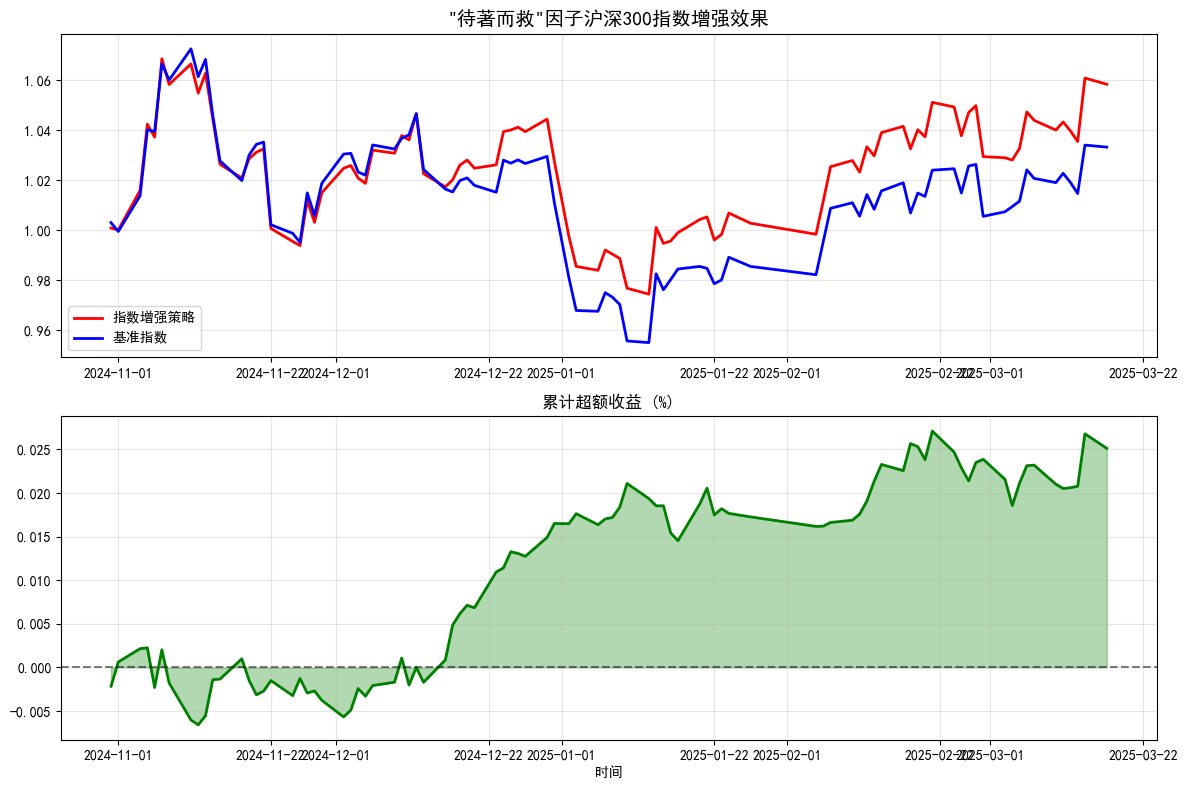

In [134]:
# 沪深300执行回测
enhanced_results = index_enhancement_backtest_with_daily_returns(final_factor, stock_df, '000300')
# 绘制累计收益曲线
plt.figure(figsize=(12, 8))

# 转换日期格式
enhanced_results['date'] = pd.to_datetime(enhanced_results['date'])

plt.subplot(2, 1, 1)
plt.plot(enhanced_results['date'], enhanced_results['portfolio_cumret'], 'r-', label='指数增强策略', linewidth=2)
plt.plot(enhanced_results['date'], enhanced_results['benchmark_cumret'], 'b-', label='基准指数', linewidth=2)
plt.title('"待著而救"因子沪深300指数增强效果', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 1, 2)
plt.fill_between(enhanced_results['date'], enhanced_results['excess_cumret'], 
                alpha=0.3, color='green', label='累计超额收益')
plt.plot(enhanced_results['date'], enhanced_results['excess_cumret'], 'g-', linewidth=2)
plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
plt.title('累计超额收益 (%)', fontsize=12)
plt.xlabel('时间')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

开始000905完整指数增强回测
📅 回测期间: 2024-10-01 ~ 2025-03-17
📊 交易日数量: 108

🔄 调仓日: 2024-10-31
✅ 获得新权重，股票数: 499
📈 2024-11-05: 组合收益 0.0330, 超额收益 0.0039

🔄 调仓日: 2024-11-29
✅ 获得新权重，股票数: 499
📈 2024-12-03: 组合收益 -0.0022, 超额收益 -0.0008

🔄 调仓日: 2024-12-31
✅ 获得新权重，股票数: 499
📈 2024-12-31: 组合收益 -0.0298, 超额收益 -0.0029

🔄 调仓日: 2025-01-27
✅ 获得新权重，股票数: 499
📈 2025-02-06: 组合收益 0.0259, 超额收益 0.0048

🔄 调仓日: 2025-02-28
✅ 获得新权重，股票数: 500
📈 2025-03-06: 组合收益 0.0165, 超额收益 0.0015

📊 回测完成！
总收益: 0.0950
基准收益: 0.0602
超额收益: 0.0349


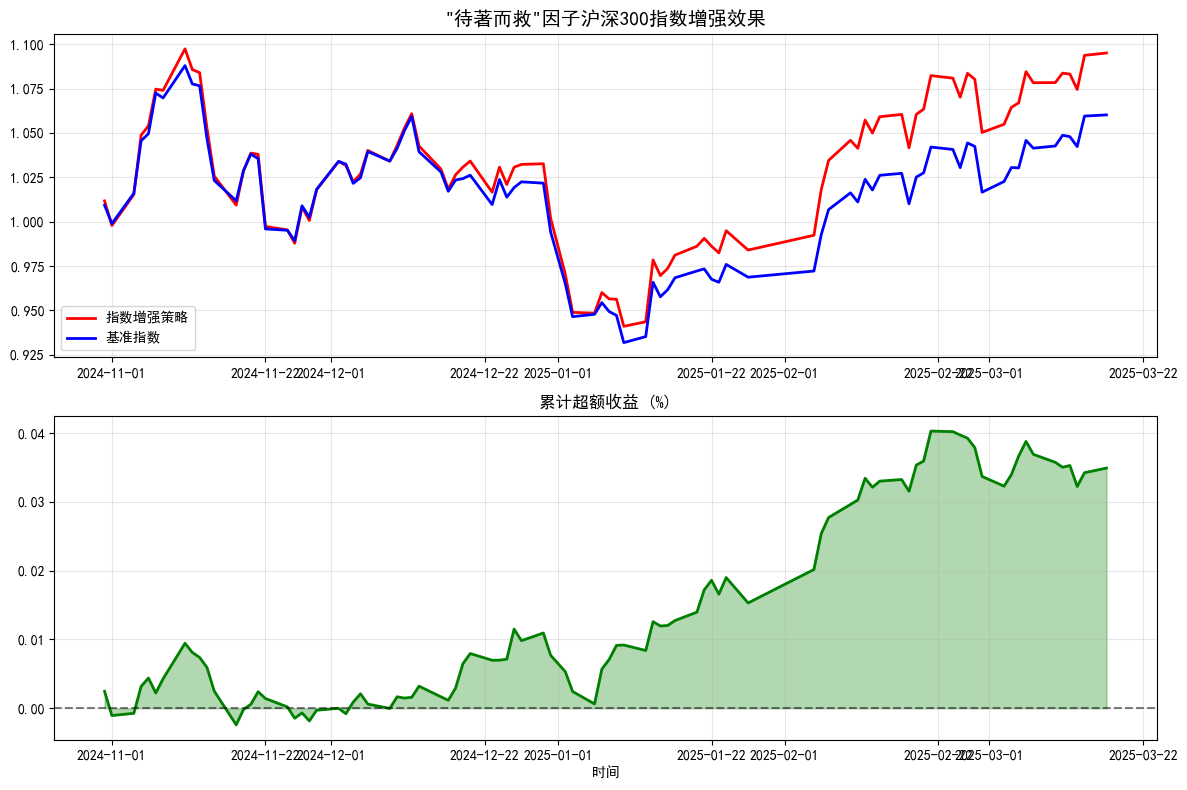

In [135]:
# 中证500执行回测
enhanced_results = index_enhancement_backtest_with_daily_returns(final_factor, stock_df, '000905')
# 绘制累计收益曲线
plt.figure(figsize=(12, 8))

# 转换日期格式
enhanced_results['date'] = pd.to_datetime(enhanced_results['date'])

plt.subplot(2, 1, 1)
plt.plot(enhanced_results['date'], enhanced_results['portfolio_cumret'], 'r-', label='指数增强策略', linewidth=2)
plt.plot(enhanced_results['date'], enhanced_results['benchmark_cumret'], 'b-', label='基准指数', linewidth=2)
plt.title('"待著而救"因子沪深300指数增强效果', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 1, 2)
plt.fill_between(enhanced_results['date'], enhanced_results['excess_cumret'], 
                alpha=0.3, color='green', label='累计超额收益')
plt.plot(enhanced_results['date'], enhanced_results['excess_cumret'], 'g-', linewidth=2)
plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
plt.title('累计超额收益 (%)', fontsize=12)
plt.xlabel('时间')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

开始000852完整指数增强回测
📅 回测期间: 2024-10-01 ~ 2025-03-17
📊 交易日数量: 108

🔄 调仓日: 2024-10-31
✅ 获得新权重，股票数: 1000
📈 2024-11-05: 组合收益 0.0364, 超额收益 0.0030

🔄 调仓日: 2024-11-29
✅ 获得新权重，股票数: 1000
📈 2024-12-03: 组合收益 -0.0026, 超额收益 -0.0007

🔄 调仓日: 2024-12-31
✅ 获得新权重，股票数: 1000
📈 2024-12-31: 组合收益 -0.0309, 超额收益 -0.0025

🔄 调仓日: 2025-01-27
✅ 获得新权重，股票数: 1000
📈 2025-02-06: 组合收益 0.0289, 超额收益 0.0051

🔄 调仓日: 2025-02-28
✅ 获得新权重，股票数: 1000
📈 2025-03-06: 组合收益 0.0217, 超额收益 0.0034

📊 回测完成！
总收益: 0.1684
基准收益: 0.1188
超额收益: 0.0496


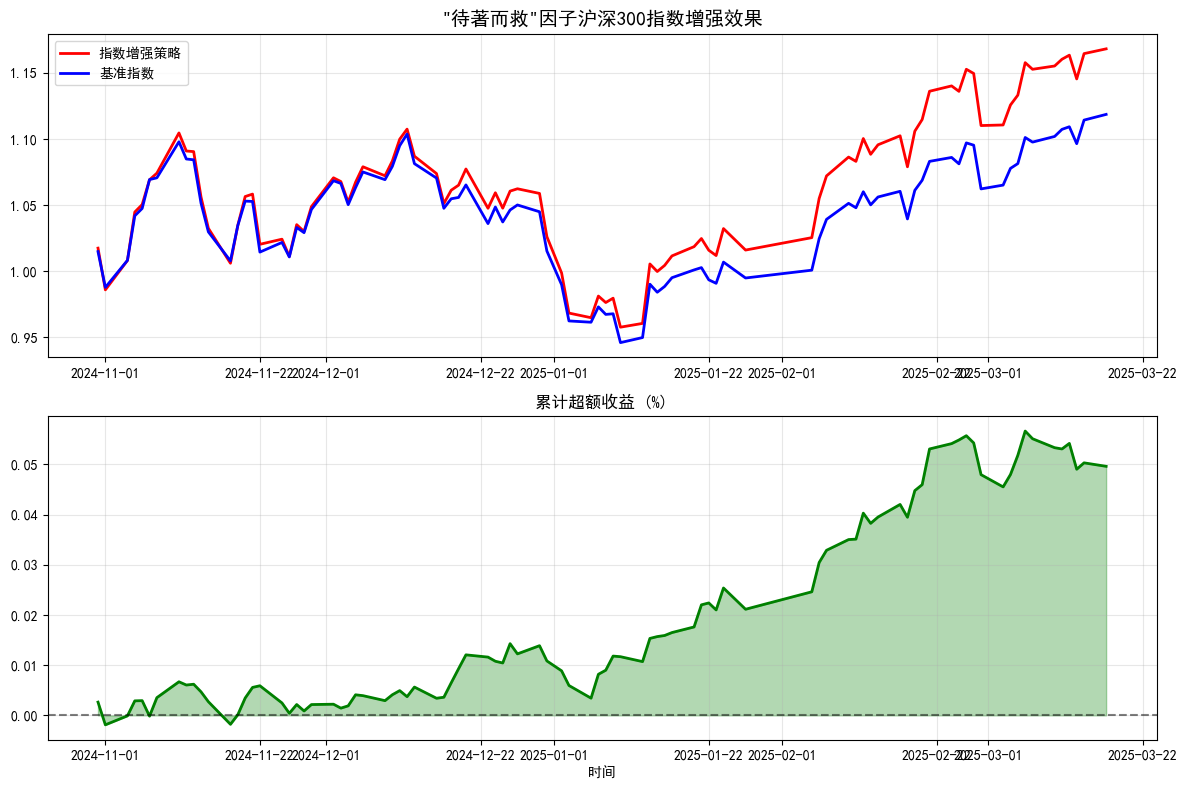

In [136]:
# 中证1000执行回测
enhanced_results = index_enhancement_backtest_with_daily_returns(final_factor, stock_df, '000852')
# 绘制累计收益曲线
plt.figure(figsize=(12, 8))

# 转换日期格式
enhanced_results['date'] = pd.to_datetime(enhanced_results['date'])

plt.subplot(2, 1, 1)
plt.plot(enhanced_results['date'], enhanced_results['portfolio_cumret'], 'r-', label='指数增强策略', linewidth=2)
plt.plot(enhanced_results['date'], enhanced_results['benchmark_cumret'], 'b-', label='基准指数', linewidth=2)
plt.title('"待著而救"因子沪深300指数增强效果', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 1, 2)
plt.fill_between(enhanced_results['date'], enhanced_results['excess_cumret'], 
                alpha=0.3, color='green', label='累计超额收益')
plt.plot(enhanced_results['date'], enhanced_results['excess_cumret'], 'g-', linewidth=2)
plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
plt.title('累计超额收益 (%)', fontsize=12)
plt.xlabel('时间')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 2.6 周频调仓情形下

周均待著而救因子：
stock_code  000001  000002  000004  000006  000007  000008  000009  000010  \
_id                                                                          
2024-09-12  2.0210  2.3580  3.2121  2.4443  1.8135  1.8310  3.2837  2.1720   
2024-09-23  2.1649  2.7964  2.6908  2.7242  2.2826  1.7325  2.9468  2.0485   
2024-09-30  2.3952  2.8243  3.1834  2.8480  2.2057  1.8642  2.8758  2.0631   
2024-10-09  2.5454  2.8914  3.2011  3.0109  2.2461  1.9578  2.9027  2.1405   
2024-10-14  2.6104  2.9225  3.1754  3.0845  2.2633  1.9972  2.8834  2.2000   

stock_code  000011  000012  000014  000016  000017  000019  000020  000021  \
_id                                                                          
2024-09-12  1.7915  1.9813  2.1224  2.0114  2.0980  2.7424  3.2447  3.1430   
2024-09-23  2.5637  1.8443  2.6344  4.3958  2.2886  2.3580  4.0363  2.9127   
2024-09-30  2.8156  1.9952  2.8582  3.6666  2.3118  2.3305  4.1740  2.8937   
2024-10-09  2.8697  2.1449  2.9856  3.4845  2.3492  2

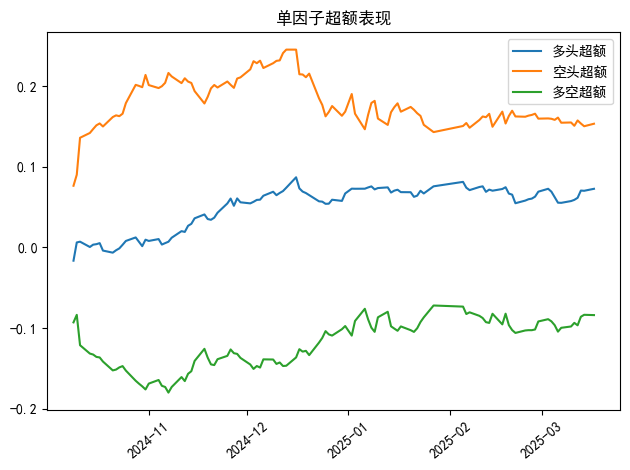

平均单边换手：0.281
年化交易成本:0.01 (未在超额中扣除)


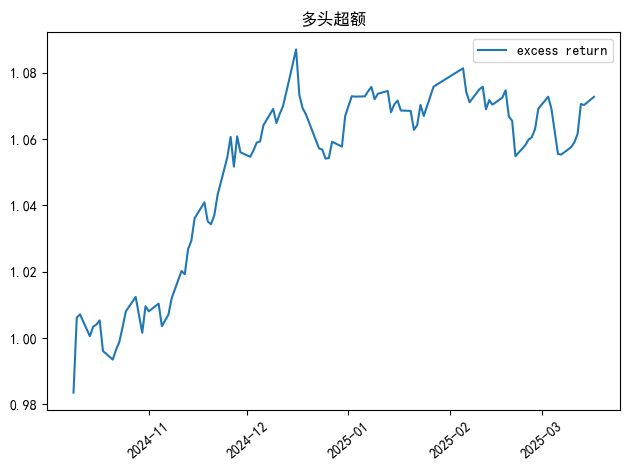


周频调仓回测结果
Rank IC: 3.59%
Rank ICIR: 0.35
t值: 1.70
年化收益率: 17.12%
年化波动率: 8.27%
信息比率: 2.07
夏普比率: 2.07
最大回撤: 3.06%


In [154]:
from config import load_data_local, prepare_dates, neutralize, backtest_stand
import numpy as np

# 1. 对每只股票计算过去20天的rolling均值和标准差（保持不变）
mean_20d = factor_pivot.rolling(window=20, min_periods=1).mean()
std_20d = factor_pivot.rolling(window=20, min_periods=1).std()

start_date = '2024-09-11'
end_date = '2025-03-17'

# 关键修改1：改为周频日期
week_end_dates = prepare_dates(start_date, end_date, fre='week')  # 改为'week'

# 关键修改2：按周末日期取数据
weekly_mean = factor_pivot.rolling(window=20, min_periods=1).mean().loc[week_end_dates]
weekly_std = factor_pivot.rolling(window=20, min_periods=1).std().loc[week_end_dates]

# 将index转回str格式的YYYY-MM-DD
weekly_mean.index = weekly_mean.index.strftime('%Y-%m-%d')
weekly_std.index = weekly_std.index.strftime('%Y-%m-%d')

# 确保columns为6位str格式的股票代码
weekly_mean.columns = weekly_mean.columns.astype(str).str.zfill(6)
weekly_std.columns = weekly_std.columns.astype(str).str.zfill(6)

# 计算合成的"待著而救"因子（等权平均）
final_factor_weekly = (weekly_mean + weekly_std) / 2
final_factor_weekly.columns = final_factor_weekly.columns.astype(str).str.zfill(6)

print("周均待著而救因子：")
print(weekly_mean.head())
print("\n周稳待著而救因子：")
print(weekly_std.head())
print("\n周频待著而救因子：")
print(final_factor_weekly.head())

# 关键修改3：周频回测
pkg_path = r'C:\Users\ZHOU\Documents\2025CUHK\兴银\需要拷的数据\\'
res_weekly = backtest_stand(
    -final_factor_weekly,  # 使用周频因子数据
    fre='week',    # 改为周频调仓
    stock_pool='888888',
    benchmark='b4',
    barra_neutral=True, 
    top=300,
    localdata_path=pkg_path+'packages/frdata',
    start='2024-10-01',
    end='2025-03-17'
)

# 计算周频回测结果
rank_ic_weekly = res_weekly['ic']['ic'].mean()
rank_icir_weekly = res_weekly['ic']['ic'].mean() / res_weekly['ic']['ic'].std()
t_value_weekly = res_weekly['ic']['ic'].mean() / (res_weekly['ic']['ic'].std() / np.sqrt(res_weekly['ic']['ic'].count()))

perf_weekly = res_weekly['多空表现']['多头表现']  
annual_return_weekly = perf_weekly.loc['年化超额', 'mean']
annual_vol_weekly = perf_weekly.loc['波动率', 'mean']
info_ratio_weekly = annual_return_weekly / annual_vol_weekly
max_drawdown_weekly = perf_weekly.loc['最大回撤', 'mean']
sharpe_ratio_weekly = annual_return_weekly / annual_vol_weekly

print("\n" + "="*50)
print("周频调仓回测结果")
print("="*50)
print(f"Rank IC: {rank_ic_weekly:.2%}")
print(f"Rank ICIR: {rank_icir_weekly:.2f}")
print(f"t值: {t_value_weekly:.2f}")
print(f"年化收益率: {annual_return_weekly:.2%}")
print(f"年化波动率: {annual_vol_weekly:.2%}")
print(f"信息比率: {info_ratio_weekly:.2f}")
print(f"夏普比率: {sharpe_ratio_weekly:.2f}")
print(f"最大回撤: {max_drawdown_weekly:.2%}")

In [147]:
res_weekly['多空持仓']['空头持仓']

[600050   0.0164
 000725   0.0156
 601728   0.0142
 688479   0.0133
 688055   0.0130
           ...  
 600693   0.0084
 002300   0.0084
 301323   0.0084
 002342   0.0084
 688070   0.0084
 Name: 2024-10-09, Length: 100, dtype: float64,
 600050   0.0160
 000725   0.0155
 600959   0.0142
 601728   0.0135
 688244   0.0130
           ...  
 688070   0.0084
 600869   0.0084
 688272   0.0083
 600880   0.0083
 000563   0.0107
 Name: 2024-10-15, Length: 101, dtype: float64,
 600050   0.0161
 000725   0.0156
 600959   0.0147
 601728   0.0140
 688479   0.0139
           ...  
 002255   0.0085
 601002   0.0085
 601869   0.0085
 002969   0.0084
 002583   0.0087
 Name: 2024-10-22, Length: 101, dtype: float64,
 600959   0.0150
 600050   0.0140
 000725   0.0140
 688479   0.0128
 688500   0.0126
           ...  
 688237   0.0107
 601399   0.0093
 002694   0.0087
 600865   0.0086
 002583   0.0087
 Name: 2024-10-29, Length: 105, dtype: float64,
 600959   0.0150
 688683   0.0138
 688060   0.0131
 002546  